In [ ]:
# TODO: is this a continuation with the "statistic" file or it's the same + more stuff? 

**TODO** <br>
- check the final percentage of missing values. 
- check, if any suggestion for missing values.
- check startyear - endyear diff. / if anything weird or more or less 10 year for series, etc.
- maybe create 3 new column for genre? / or exploding it into new rows?

Change: tconst to title_id <br>
Explode genres <br>
Also in title_akas change title_id to be aligned <br>
title_akas title to primaryTitle or originalTitle?
split the types() in title_akas

# Importing libraries and listing ressources

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted

from google.colab import drive
drive.mount("/content/drive")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Reading the dataframe
title_basics = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", sep = "\t")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Ressources: 
- https://www.imdb.com/interfaces/

Schedule: 
- https://trello.com/b/8q3PCqwa/abba

"title.basics" contains the following information for titles:
- **tconst (string)** - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

# Exploring title.basics table & defining conclusions

In [ ]:
# pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", sep = "\t").info()

# I have put the reading to the first section, so whenever my memory crashes I do not need to jump to this section
# title_basics = pd.read_csv("https://datasets.imdbws.com/title.basics.tsv.gz", sep = "\t")
print(title_basics.info())
print(title_basics.head(10))
print(title_basics.tail(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8442834 entries, 0 to 8442833
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 579.7+ MB
None
      tconst titleType  ... runtimeMinutes                    genres
0  tt0000001     short  ...              1         Documentary,Short
1  tt0000002     short  ...              5           Animation,Short
2  tt0000003     short  ...              4  Animation,Comedy,Romance
3  tt0000004     short  ...             12           Animation,Short
4  tt0000005     short  ...              1              Comedy,Short
5  tt0000006     short  ...              1                     Short
6  tt0000007     short  ...              1        

**Conclusion 1**<br>
All data is coded as object,i.e.string which is not correct for:
- isAdult -> boolean;
- start year and end year -> int.
- runtime minutes -> int. 
- tconst is not descriptive. suggestion: t_id or title_id

Missing values might not be coded correctly: \N. ("\\N")

In [ ]:
#Renaming Columns
title_basics.rename(columns={'tconst':'title_id'},inplace=True)
title_basics

,title_id,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
8442829,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,\N,\N,"Action,Drama,Family"
8442830,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
8442831,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
8442832,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [ ]:
# Null values per column:
for column in title_basics:
  print(column, "num of missing values: ", title_basics[column].isna().sum())

# TODO: are these missing values all in the same row? If they are, we could just drop the row, no?

title_id num of missing values:  0
titleType num of missing values:  0
primaryTitle num of missing values:  9
originalTitle num of missing values:  9
isAdult num of missing values:  0
startYear num of missing values:  0
endYear num of missing values:  0
runtimeMinutes num of missing values:  0
genres num of missing values:  10


So that let's see unique values.

In [ ]:
# How many unique values we have per column:
for column in title_basics:
  print(column, "the number of unique values", len(title_basics[column].unique()))

title_id the number of unique values 8442834
titleType the number of unique values 11
primaryTitle the number of unique values 4013425
originalTitle the number of unique values 4032401
isAdult the number of unique values 11
startYear the number of unique values 256
endYear the number of unique values 97
runtimeMinutes the number of unique values 856
genres the number of unique values 2299


**Conclusion 2**<br>
Seems that indeed, only t_id is unique for all row, either duplicates or missing data is in primaryTitle, originalTitle, etc.
But we can have a look into titleType and isAdult, because the length of unique values is limited.

In [ ]:
print(title_basics["titleType"].value_counts())
print(title_basics["isAdult"].value_counts())

tvEpisode       6214630
short            841130
movie            593723
video            328204
tvSeries         216089
tvMovie          133638
tvMiniSeries      40585
tvSpecial         34783
videoGame         29684
tvShort           10366
tvPilot               2
Name: titleType, dtype: int64
0       8120804
1        256485
0         63333
1          2202
2019          3
2020          2
\N            1
2017          1
2014          1
2005          1
1981          1
Name: isAdult, dtype: int64


In [ ]:
title_basics[title_basics["titleType"] == "videoGame"]
# Checked Brain Age Express: Math and King's Quest VII - they are indeed videoGames. -> drop them? # TODO: yes, if you have a good reason

,title_id,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
82563,tt0084376,videoGame,"MysteryDisc: Murder, Anyone?","MysteryDisc: Murder, Anyone?",0,1982,\N,\N,"Adventure,Crime,Mystery"
84118,tt0085982,videoGame,MysteryDisc: Many Roads to Murder,MysteryDisc: Many Roads to Murder,0,1983,\N,\N,"Adventure,Crime,Mystery"
102707,tt0105000,videoGame,Night Trap,Night Trap,0,1992,\N,\N,"Adventure,Horror,Mystery"
107464,tt0109865,videoGame,Gabriel Knight: Sins of the Fathers,Gabriel Knight: Sins of the Fathers,0,1993,\N,\N,"Adventure,Drama,Horror"
107857,tt0110267,videoGame,King's Quest VII: The Princeless Bride,King's Quest VII: The Princeless Bride,0,1994,\N,\N,"Adventure,Fantasy"
...,...,...,...,...,...,...,...,...,...
8441054,tt9913072,videoGame,Brain Age Express: Math,Brain Age Express: Math,0,2008,\N,\N,\N
8441066,tt9913096,videoGame,Brain Age Express: Arts & Letters,Brain Age Express: Arts & Letters,0,2008,\N,\N,\N
8441194,tt9913388,videoGame,Brain Age Express: Sudoku,Brain Age Express: Sudoku,0,2009,\N,\N,\N
8442393,tt9915932,videoGame,Aero Dancing F,Aero Dancing F,0,2000,\N,\N,\N


Let's try to explore more about string columns, why there are so many duplicates and so less missing value. <br>
**primaryTitle**

In [ ]:
#So for title_basics["primaryTitle"] unfortunately you cannot know, which is "good" and "bad"
title_basics.sort_values(by = ["primaryTitle"])

,title_id,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
5036445,tt2386381,tvSeries,!Next?,!Next?,0,1994,1995,\N,Documentary
4754726,tt2071912,tvEpisode,!Que ve el Bisbe!,!Que ve el Bisbe!,0,2011,\N,\N,Comedy
4397996,tt1699720,movie,!Women Art Revolution,Women Art Revolution,0,2010,\N,83,Documentary
8090876,tt9172970,tvEpisode,#,#,0,\N,\N,\N,Romance
5048182,tt2399574,short,#,#,0,2012,\N,15,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
4749991,tt2067043,tvEpisode,NaN,NaN,0,1965,\N,\N,Music
6522330,tt5773048,tvEpisode,NaN,NaN,0,2015,\N,\N,Talk-Show
7764642,tt8473688,tvEpisode,NaN,NaN,0,1987,\N,\N,Drama
7796290,tt8541336,tvEpisode,NaN,NaN,0,2018,\N,\N,"Reality-TV,Romance"


In [ ]:
title_basics[title_basics["primaryTitle"] == "\\N"] 
# No result

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres


In [ ]:
title_basics[title_basics["primaryTitle"] == "#"] 
# Okay, not giving me many results neither.

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
4986493,tt2399574,short,#,#,0,2012,\N,15,"Comedy,Short"
5565959,tt3762918,short,#,#,0,2014,\N,\N,"Comedy,Short"
6900917,tt6748908,short,#,#,0,2012,\N,8,"Animation,Short"
8029201,tt9172970,tvEpisode,#,#,0,\N,\N,\N,Romance


In [ ]:
# You can also search for duplicates in a dataset (.duplicated)
# I wanted to see here the pattern of the duplicates, if there is anything else, 
# what we can filter out as pure mistake
# But nothing else found

title_basics[title_basics.duplicated(subset = "primaryTitle")].sort_values(by="primaryTitle").head(20)

,title_id,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
6962598,tt6748908,short,#,#,0,2012,\N,8,"Animation,Short"
5627643,tt3762918,short,#,#,0,2014,\N,\N,"Comedy,Short"
8090876,tt9172970,tvEpisode,#,#,0,\N,\N,\N,Romance
1358672,tt10688704,tvEpisode,#1,#1,0,\N,\N,\N,Comedy
4741199,tt2057889,short,#1,#1,0,2010,\N,12,"Comedy,Short"
4313110,tt1611790,video,#1,#1,0,2010,\N,12,"Comedy,Drama,News"
7037208,tt6915008,movie,#1,#1,0,\N,\N,\N,Documentary
7201021,tt7267690,tvEpisode,#1,#1,0,2017,\N,\N,"Comedy,Documentary,Drama"
7777723,tt8501744,tvEpisode,#1,#1,0,2016,\N,\N,Drama
4505367,tt1813109,video,#1,#1,0,2010,\N,3,"Animation,Drama,Short"


In [ ]:
title_basics[title_basics.duplicated(subset = "primaryTitle")].sort_values(by="primaryTitle").tail(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
3975470,tt15372970,tvEpisode,Þáttur 5,Þáttur 5,0,2021,\N,\N,Reality-TV
3970483,tt15362806,tvEpisode,Þáttur 5,Þáttur 5,0,2017,\N,\N,Documentary
6759367,tt6440676,tvEpisode,Þáttur 5,Þáttur 5,0,2010,\N,\N,Comedy
3975441,tt15372920,tvEpisode,Þáttur 6,Þáttur 6,0,2021,\N,\N,Reality-TV
3975407,tt15372864,tvEpisode,Þáttur 6,Þáttur 6,0,2020,\N,\N,Reality-TV
6759369,tt6440682,tvEpisode,Þáttur 6,Þáttur 6,0,2010,\N,\N,Comedy
3975472,tt15372976,tvEpisode,Þáttur 6,Þáttur 6,0,2021,\N,\N,Reality-TV
6759372,tt6440688,tvEpisode,Þáttur 7,Þáttur 7,0,2010,\N,\N,Comedy
3975477,tt15372984,tvEpisode,Þáttur 7,Þáttur 7,0,2021,\N,\N,Reality-TV
6759373,tt6440692,tvEpisode,Þáttur 8,Þáttur 8,0,2010,\N,\N,Comedy


In [ ]:
title_basics[title_basics["primaryTitle"] == "Blacksmith Scene"]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
20,tt0000022,short,Blacksmith Scene,Les forgerons,0,1895,\N,1,"Documentary,Short"


**originalTitle**

In [ ]:
title_basics[title_basics["originalTitle"] == "\\N"] 
# No result

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres


In [ ]:
title_basics[title_basics["originalTitle"] == "#"] 
# Same 4 lines as for primaryTitle

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
4986493,tt2399574,short,#,#,0,2012,\N,15,"Comedy,Short"
5565959,tt3762918,short,#,#,0,2014,\N,\N,"Comedy,Short"
6900917,tt6748908,short,#,#,0,2012,\N,8,"Animation,Short"
8029201,tt9172970,tvEpisode,#,#,0,\N,\N,\N,Romance


In [ ]:
title_basics[title_basics.duplicated(subset = "originalTitle")].sort_values(by="originalTitle").head(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8029201,tt9172970,tvEpisode,#,#,0,\N,\N,\N,Romance
5565959,tt3762918,short,#,#,0,2014,\N,\N,"Comedy,Short"
6900917,tt6748908,short,#,#,0,2012,\N,8,"Animation,Short"
4443677,tt1813109,video,#1,#1,0,2010,\N,3,"Animation,Drama,Short"
7139341,tt7267690,tvEpisode,#1,#1,0,2017,\N,\N,"Comedy,Documentary,Drama"
4251420,tt1611790,video,#1,#1,0,2010,\N,12,"Comedy,Drama,News"
2881702,tt13409842,short,#1,#1,0,2020,\N,\N,"Comedy,Short"
6975527,tt6915008,movie,#1,#1,0,\N,\N,\N,Documentary
1358785,tt10688704,tvEpisode,#1,#1,0,\N,\N,\N,Comedy
5605519,tt3852602,short,#1,#1,0,2009,\N,4,"Animation,Short"


In [ ]:
title_basics[title_basics.duplicated(subset = "originalTitle")].sort_values(by="originalTitle").tail(20)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
3975470,tt15372970,tvEpisode,Þáttur 5,Þáttur 5,0,2021,\N,\N,Reality-TV
3970483,tt15362806,tvEpisode,Þáttur 5,Þáttur 5,0,2017,\N,\N,Documentary
3975404,tt15372858,tvEpisode,Þáttur 5,Þáttur 5,0,2020,\N,\N,Reality-TV
3975472,tt15372976,tvEpisode,Þáttur 6,Þáttur 6,0,2021,\N,\N,Reality-TV
3975441,tt15372920,tvEpisode,Þáttur 6,Þáttur 6,0,2021,\N,\N,Reality-TV
3975407,tt15372864,tvEpisode,Þáttur 6,Þáttur 6,0,2020,\N,\N,Reality-TV
6759369,tt6440682,tvEpisode,Þáttur 6,Þáttur 6,0,2010,\N,\N,Comedy
3975477,tt15372984,tvEpisode,Þáttur 7,Þáttur 7,0,2021,\N,\N,Reality-TV
6759372,tt6440688,tvEpisode,Þáttur 7,Þáttur 7,0,2010,\N,\N,Comedy
6759373,tt6440692,tvEpisode,Þáttur 8,Þáttur 8,0,2010,\N,\N,Comedy


In [ ]:
# TODO: so? Any action on the duplicates? What's the decision? What's the situation?

**startYear**

In [ ]:
title_basics["startYear"].unique()

array([1894, 1892, 1893, 1895, 1896, 1898, 1897, 1900, 1899, 1901, 1902,
       1903, 1905, 1904, 1912, 1907, 1906, 1908, 1910, 1909, 1914, 1911,
       1913, 1915, 1919, 1916, 1917, 1918, 1936, 1925, 1920, 1922, 1921,
       1923, 2019, 1924, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014,
       1930, 1942, 1934, 1931, 1932, 1939, 1937, 1933, 1950, 1938, 1951,
       1945, 1946, 1996, 1940, 1944, 1949, 1947, 1941, 1952, 1970, 1957,
       1943, 1959, 1948, 2001, 1953, 2008, 1954, 1965, 1983, 1980, 1973,
       1961, 1995, 1955, 1962, 1958, 1956, 1977, 1960, 1964, 1967, 1968,
       1963, 1986, 1971, 1969, 1972, 1966, 2021, 2002, 1976, 1990, 2020,
       1979, 1974, 1978, 1981, 1988, 1975, 1989, '1971', '1972', '1970',
       '1974', '1973', '1976', '1969', '1968', '1985', '\\N', '1981',
       '2009', '1980', '1986', '1965', '1987', '1975', '1978', '1967',
       '1990', '1977', '2010', '2018', '1979', '2007', '1989', '1983',
       '1988', '1984', '1966', '1982', '1992', '1991', '19

**endYear**

In [ ]:
title_basics["endYear"].unique()

array(['\\N', '1934', '1947', '1945', '1955', '1949', '1958', '1951',
       '1950', '1952', '1954', '1957', '1953', '1956', '1967', '1971',
       '1959', '1963', '1960', '1961', '1965', '1980', '2016', '1986',
       '1962', '1972', '1966', '1970', '2009', '1973', '1987', '1997',
       '1974', '1992', '1976', '1975', '1982', '2010', '1984', '1964',
       '1968', '1989', '1969', '1994', '2004', '1981', '1999', '1988',
       '1985', '2003', '1977', '1978', '1993', '2001', '2013', '1996',
       '2011', '2005', '1995', '1979', '2006', '1983', '1990', '1998',
       '2008', '1991', '2020', '2007', '2021', '2018', '2015', '2014',
       '2000', '2019', '2002', '2012', '2022', '2017', '1948', '1938',
       '1942', '1933', '2026', '1944', '1946', '2024', '2023', '1937',
       '2030', '2028', '2025', '1941', '1939', '1932', '1936', '1935',
       '2027'], dtype=object)

**runtimeMinutes**

In [ ]:
title_basics["runtimeMinutes"].unique()

array(['1', '5', '4', '12', '40', '2', '\\N', '0', '3', '20', '13', '6',
       '11', '9', '10', '8', '15', '21', '16', '14', '7', '24', '100',
       '17', '70', '90', '25', '120', '36', '18', '30', '19', '44', '38',
       '58', '45', '50', '34', '28', '22', '35', '42', '23', '51', '52',
       '60', '92', '56', '53', '31', '41', '48', '68', '33', '29', '71',
       '43', '46', '27', '32', '76', '85', '55', '121', '89', '26', '37',
       '69', '54', '150', '64', '96', '49', '61', '39', '101', '300',
       '57', '99', '110', '88', '86', '170', '72', '78', '75', '450',
       '148', '124', '220', '59', '63', '112', '1428', '84', '65', '74',
       '105', '310', '73', '82', '81', '199', '139', '109', '67', '219',
       '80', '195', '440', '77', '293', '97', '62', '47', '250', '421',
       '360', '180', '66', '93', '163', '400', '104', '95', '140', '165',
       '116', '83', '320', '125', '127', '138', '460', '350', '374',
       '480', '91', '87', '130', '108', '79', '136', '94', '6

**genre** in theory it should be only up to 3 type. Is it true?
Are they all and always separated by comma?

In [ ]:
genre1 = []
genre2 = []
genre3 = []

# To be refactored, too long for - if 
for item in title_basics["genres"].unique():
  if type(item) == float:
    print(item)
  else:
    item_list = item.split(",")
    if len(item_list) == 1:
      genre1.append(item_list[0])
    elif len(item_list) == 2:
      genre1.append(item_list[0])
      genre2.append(item_list[1])
    elif len(item_list) == 3:
      genre1.append(item_list[0])
      genre2.append(item_list[1])
      genre3.append(item_list[2])
    else:
      print("Something is wrong here!")

print(sorted(list(set(genre1))))
print(sorted(list(set(genre2))))
print(sorted(list(set(genre3))))
# Seems that here there is a lot of consistency: data is indeed separated by comma, there is no string, which is longer then 3 types and the genre types are having the same kind of spelling (i.e. no Game Show and Game-Show)

nan
['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western', '\\N']
['Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']
['Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


**Conclusion 3**<br>
- isAdult: True - False 0/1 is also mixed, i.e. int./string. **transformed to boolean**
- isAdult: low nr. of completely mistyped data 10 labelled with year / non-existing. //**mistyped info converted to nan**
- titleType: videoGame seems to be odd in this database. -> **Shall we drop them?**
- primaryTitle: also # is used for missing value. **converted to nan**
- primaryTitle: some duplicates is not really clear, which one to use / i.e. really duplicate or not. Seems that in some subcategories however there are more duplicates than in others, i.e. tvEpisode, short. / Not sure, how to validate this.
- originalTitle: also # is used for missing value (same rows as for primaryTitle). **converted to nan**
- originalTitle: some duplicates is not really clear, which one to use / i.e. really duplicate or not. Seems that in some subcategories however there are more duplicates than in others, i.e. tvEpisode, short. / Not sure, how to validate this. maybe sort by titleType?
- startYear: int and string for years is mixed. \\N is used for missing info. -> transform string to int., update \N to NaN // **done**
- endYear: all nr.is string instead of int. \\N for Nan. // **done**
- runtimeMinutes: all nr.is string instead of int. \\N for Nan. Some random string / i.e.data from other columns? Outlier length: is it because of type or clear error? **done**
- genres: very good column with respect to consistency.

# Cleaning the title_basics

**endYear** -> endYear_clean

In [ ]:
# Let's start with endYear, because it is the most simple to convert.
# -"\\N" to nan, 
# -type to int
# -outlier / strange check afterwards
# title_basics[title_basics["endYear"] == "\\N"] # 8286677 rows
# And all remaining data is as string
# title_basics["endYear"].unique() # already seen above

In [ ]:
# So that first if value is numeric change to int / else to np.nan
title_basics["endYear_clean"] = title_basics["endYear"].apply(lambda x: int(x) if x.isnumeric() == True else np.nan) 

In [ ]:
# Change type of the column to int
title_basics["endYear_clean"] = title_basics["endYear_clean"].astype(dtype = pd.Int64Dtype())

In [ ]:
# Check if replacement is correct
# print(title_basics["endYear_clean"].unique())
# print(title_basics["endYear_clean"].value_counts())

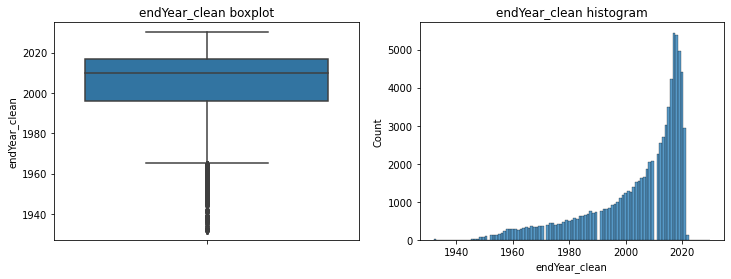

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(ax = axes[0],
            y=title_basics["endYear_clean"])

sns.histplot(ax = axes[1],
             data = title_basics,
             x = title_basics["endYear_clean"])
axes[0].set_title("endYear_clean boxplot")
axes[1].set_title("endYear_clean histogram")
plt.show()
# Data looks good

In [ ]:
# TODO: why are there missing bars in the barplot?

**startYear** -> startYear_clean

In [ ]:
# Next startYear
# -"\\N" to nan, 
# -type to int
# -outlier / strange check afterwards
# title_basics[title_basics["startYear"] == "\\N"] # 1018186 rows
# And all remaining data is either string or int

In [ ]:
# Create a new column for clean data: 1) replace \\N with 0
title_basics["startYear_clean"] = title_basics["startYear"].apply(lambda x: x if type(x) == int else int(x) if x.isnumeric() == True else np.nan) 

In [ ]:
# Change type of the column to int
title_basics["startYear_clean"] = title_basics["startYear_clean"].astype(dtype = pd.Int64Dtype())

In [ ]:
# Check if replacement is correct 
# print(title_basics["startYear_clean"].unique())
# print(title_basics["startYear_clean"].value_counts())

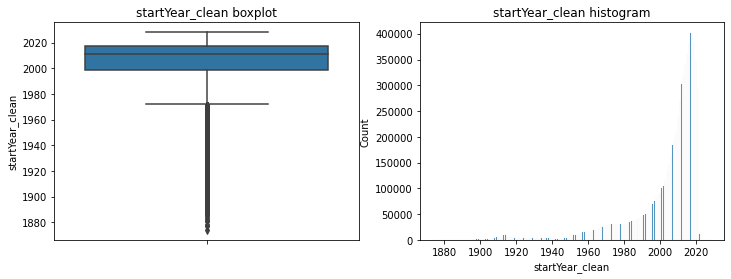

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(ax = axes[0],
            y=title_basics["startYear_clean"])

sns.histplot(ax = axes[1],
             data = title_basics,
             x = title_basics["startYear_clean"])
axes[0].set_title("startYear_clean boxplot")
axes[1].set_title("startYear_clean histogram")
plt.show()
# Data looks good
# More outlier / movie from 1880 
# Also the start_year seem to be less continuous / more central around certain years.

In [ ]:
# TODO: is there a pattern in the startYear? (if so, the whole clumn could be useless)

**isAdult** -> isAdult_clean

In [ ]:
# Third step is isAdult column
# -"\\N" to nan
# -0 as "0", 1 as "1"
# -some completely not matching data (2019, 2020, 2017, 2014...)
# -type to boolean
# print(title_basics["isAdult"].value_counts())

In [ ]:
# Since it was a limited list, I did it manually first:
# title_basics["isAdult_clean"] = title_basics["isAdult"].replace({"\\N": -1, "0": 0, "1": 1, 2019: -1, 2020: -1, 2017: -1, 2014: -1, 2005: -1, 1981: -1})

# But I can do it also with lambda, so let's try:
# lambda x: x if x ==0, x if x== 1, 0 if x== "0", 1 if x == "1", nan else
title_basics["isAdult_clean"] = title_basics["isAdult"].apply(lambda x: x if x == 0 or x ==1 else 0 if x == "0" else 1 if x == "1" else np.nan)
# TODO: great work with the lambda function

In [ ]:
# Change type of the column to boolean
title_basics["isAdult_clean"] = title_basics["isAdult_clean"].astype(dtype = "boolean")

In [ ]:
# Check if replacement is correct 
# title_basics["isAdult_clean"].value_counts()

**runtimeMinutes** ->runTimeMin_clean

In [ ]:
# runtimeMinutes
# -"\\N" to nan, 
# -type to int
# -outlier / strange check afterwards
# -some random string in this column, i.e. "Animation, Comedy, Family"
# title_basics["runtimeMinutes"].unique() # already seen above
# And all numerical data is string

In [ ]:
# Apply lambda as previously
title_basics["runTimeMin_clean"] = title_basics["runtimeMinutes"].apply(lambda x: int(x) if x.isnumeric() == True else np.nan) 

In [ ]:
# Change type of the column to int
title_basics["runTimeMin_clean"] = title_basics["runTimeMin_clean"].astype(dtype = pd.Int64Dtype())

In [ ]:
# Check if replacement is correct 
# print(title_basics["runTimeMin_clean"].unique())
# print(title_basics["runTimeMin_clean"].value_counts())

In [ ]:
#@title
# -9223372036854775808 was the pd.NaT "value" // but it was distorting the data considerably 
# Luckily found the correct way to include missing and convert to int
 
#title_basics[title_basics["runTimeMin_clean"] == -9223372036854775808] # 6012830 rows
#title_basics[title_basics["runtimeMinutes"] == "\\N"] # 6012823 rows
#title_basics[(title_basics["runtimeMinutes"] != "\\N") & (title_basics["runTimeMin_clean"] == -9223372036854775808)] # 7 rows, where runtimeMinutes was string "genres"

In [ ]:
title_basics["runTimeMin_clean"].describe()
# 75 % of data is below 60 // which makes sense as it is one hour

count    2.358588e+06
mean     4.359585e+01
std      7.236583e+01
min      0.000000e+00
25%      1.500000e+01
50%      3.000000e+01
75%      6.000000e+01
max      5.142000e+04
Name: runTimeMin_clean, dtype: float64

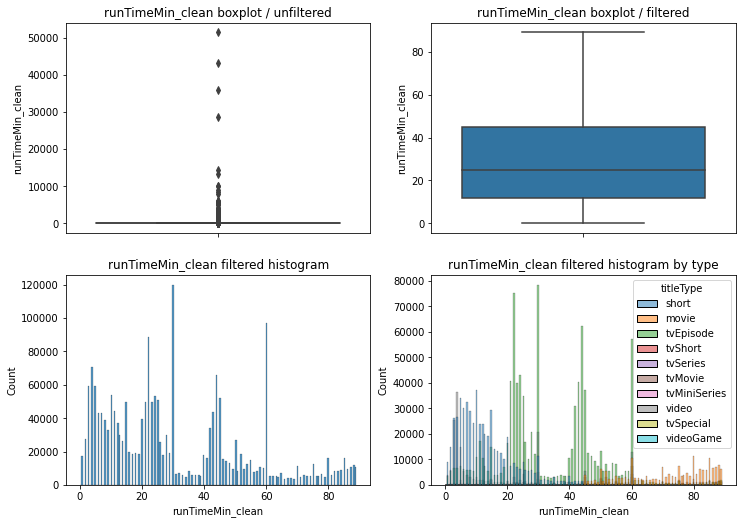

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (12,8.5))

# --- BOXPLOTS (un)filtered --- #
sns.boxplot(ax = axes[0,0],
            y=title_basics["runTimeMin_clean"])
sns.boxplot(ax = axes[0,1],
            y=title_basics["runTimeMin_clean"][title_basics["runTimeMin_clean"]<90])

# --- HISTOGRAMS filtered --- #
sns.histplot(ax = axes[1,0],
             data = title_basics[title_basics["runTimeMin_clean"]<90],
             x = title_basics["runTimeMin_clean"][title_basics["runTimeMin_clean"]<90])
sns.histplot(ax = axes[1,1],
             data = title_basics[title_basics["runTimeMin_clean"]<90],
             x = title_basics["runTimeMin_clean"][title_basics["runTimeMin_clean"]<90],
             hue = "titleType")

axes[0,0].set_title("runTimeMin_clean boxplot / unfiltered")
axes[0,1].set_title("runTimeMin_clean boxplot / filtered")
axes[1,0].set_title("runTimeMin_clean filtered histogram")
axes[1,1].set_title("runTimeMin_clean filtered histogram by type")
plt.show()

# Data looks good
# Some very strange outlier / movies(?) with length above 50 kmin?
# the histogram is not following "normal distribution" / maybe some subcategories, but seems that not type

In [ ]:
# TODO: the (2,2) plot is not very clear. What do you want to communicate?

Text(0.5, 1.0, 'Does the average lenght of the films get longer over the years')

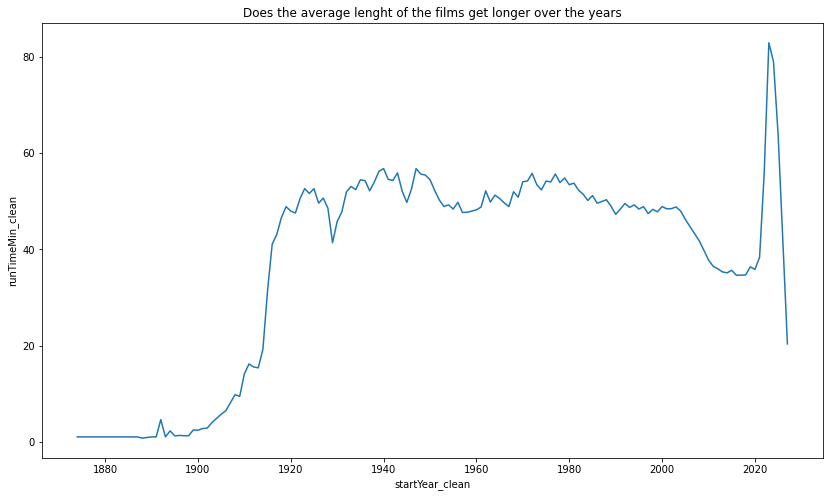

In [ ]:
# The lineplot is filtered with runTimeMin_clean < 180 minutes to remove outliers
film_lenght_mean = title_basics[title_basics["runTimeMin_clean"]<180].pivot_table(values='runTimeMin_clean',columns='startYear_clean',aggfunc='mean').T
film_lenght_mean.sort_values(by='startYear_clean',inplace=True)
plt.figure(figsize=(14,8))
sns.lineplot(data=film_lenght_mean, x='startYear_clean',y='runTimeMin_clean')
plt.title("Does the average lenght of the films get longer over the years")
#film_lenght_mean.plot()

In [ ]:
# TODO: nice work :D

In [ ]:
title_basics[title_basics["runTimeMin_clean"] == 51420.0]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,endYear_clean,startYear_clean,isAdult_clean,runTimeMin_clean
7608457,tt8273150,movie,Logistics,Logistics,0,2012,\N,51420,Documentary,<NA>,2012,False,51420


In [ ]:
# Changing the 4 rows with "#" to nan
title_basics["pT_clean"] = title_basics["primaryTitle"].apply(lambda x: np.nan if x == "#" else x) 
title_basics["oT_clean"] = title_basics["originalTitle"].apply(lambda x: np.nan if x == "#" else x) 

In [ ]:
title_basics.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres', 'endYear_clean',
       'startYear_clean', 'isAdult_clean', 'runTimeMin_clean', 'pT_clean',
       'oT_clean'],
      dtype='object')

In [ ]:
print(title_basics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8419764 entries, 0 to 8419763
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   tconst            object 
 1   titleType         object 
 2   primaryTitle      object 
 3   originalTitle     object 
 4   isAdult           object 
 5   startYear         object 
 6   endYear           object 
 7   runtimeMinutes    object 
 8   genres            object 
 9   endYear_clean     Int64  
 10  startYear_clean   Int64  
 11  isAdult_clean     boolean
 12  runTimeMin_clean  Int64  
 13  pT_clean          object 
 14  oT_clean          object 
dtypes: Int64(3), boolean(1), object(11)
memory usage: 939.5+ MB
None


In [ ]:
for column in title_basics:
  print(column, "num of missing values: ", title_basics[column].isna().sum())

tconst num of missing values:  0
titleType num of missing values:  0
primaryTitle num of missing values:  9
originalTitle num of missing values:  9
isAdult num of missing values:  0
startYear num of missing values:  0
endYear num of missing values:  0
runtimeMinutes num of missing values:  0
genres num of missing values:  10
endYear_clean num of missing values:  8297559
startYear_clean num of missing values:  1021271
isAdult_clean num of missing values:  10
runTimeMin_clean num of missing values:  6022596
pT_clean num of missing values:  13
oT_clean num of missing values:  13


Now that I'm thinking one can do all this in one step for multiple columns, where the same transformations have to be carried out. 

In [ ]:
# Sth.like this:
"""for column in title_basics:
  [column concat clean] do lambda / replace nan convert to int
  change type"""

'for column in title_basics:\n  [column concat clean] do lambda / replace nan convert to int\n  change type'

# Exploring and cleaning title.ratings table

"title.ratings.tsv.gz" – Contains the IMDb rating and votes information for titles:
- **tconst (string)** - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received


In [ ]:
title_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep = "\t")

In [ ]:
title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201509 entries, 0 to 1201508
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1201509 non-null  object 
 1   averageRating  1201509 non-null  float64
 2   numVotes       1201509 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 27.5+ MB


In [ ]:
title_ratings.head(10)

,tconst,averageRating,numVotes
0,tt0000001,5.7,1834
1,tt0000002,6.0,236
2,tt0000003,6.5,1594
3,tt0000004,6.0,153
4,tt0000005,6.2,2411
5,tt0000006,5.2,158
6,tt0000007,5.4,755
7,tt0000008,5.5,1982
8,tt0000009,5.9,191
9,tt0000010,6.9,6604


In [ ]:
title_ratings["averageRating"].describe()

count    1.201148e+06
mean     6.924606e+00
std      1.394576e+00
min      1.000000e+00
25%      6.200000e+00
50%      7.100000e+00
75%      7.900000e+00
max      1.000000e+01
Name: averageRating, dtype: float64

In [ ]:
#Renaming Columns
title_ratings.rename(columns={'tconst':'title_id'},inplace=True)
title_ratings

,title_id,averageRating,numVotes
0,tt0000001,5.7,1834
1,tt0000002,6.0,236
2,tt0000003,6.5,1594
3,tt0000004,6.0,153
4,tt0000005,6.2,2411
...,...,...,...
1201504,tt9916682,5.6,5
1201505,tt9916690,6.6,5
1201506,tt9916720,5.2,147
1201507,tt9916766,7.1,17


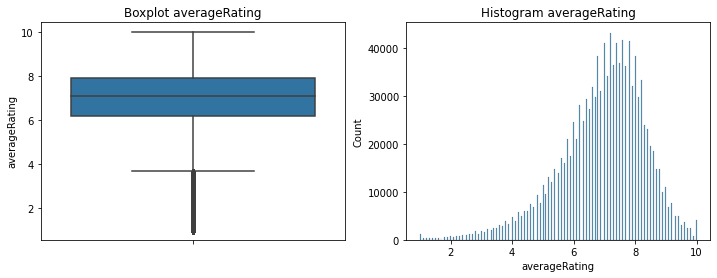

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (12,4))


sns.boxplot(ax = axes[0],
            data = title_ratings,
            y = "averageRating")
sns.histplot(ax = axes[1],
             data = title_ratings,
            x = "averageRating")
axes[0].set_title("Boxplot averageRating")
axes[1].set_title("Histogram averageRating")
plt.show()

# Data looks good
# Histogram in the direction of normal distribution
# Some outliers, but not super relevant

In [ ]:
title_ratings["numVotes"].describe()

count    1.201509e+06
mean     9.792134e+02
std      1.638474e+04
min      5.000000e+00
25%      1.100000e+01
50%      2.400000e+01
75%      9.200000e+01
max      2.484590e+06
Name: numVotes, dtype: float64

In [ ]:
print(9.783303e+02)

978.3303


From above data seems that there are many movies with very low nr. of votes.<br> Median = 24, meaning that half of the dataset has less than 24 votes.<br>
75% of the data has 92 votes in total. <br>
<br>
Max.of numVotes however is 2.47 M.

In [ ]:
# TODO: is there any difference etween the movies with less than 24 votes and the ones who have more than 24 votes?

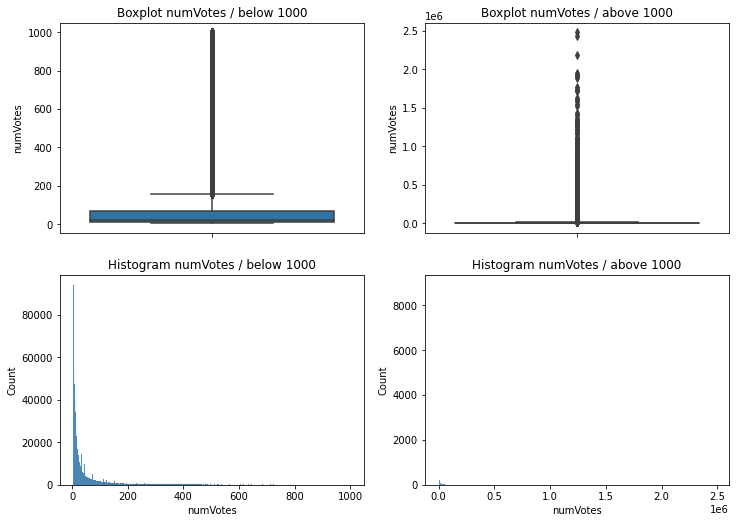

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (12,8.5))

# --- BOXPLOTS filtered --- #
sns.boxplot(ax = axes[0,0],
            data = title_ratings[title_ratings["numVotes"]<1000],
            y = title_ratings["numVotes"][title_ratings["numVotes"]<1000])
sns.boxplot(ax = axes[0,1],
            data = title_ratings[title_ratings["numVotes"]>=1000],
            y = title_ratings["numVotes"][title_ratings["numVotes"]>=1000])

# --- HISTOGRAMS filtered --- #
sns.histplot(ax = axes[1,0],
             data = title_ratings[title_ratings["numVotes"]<1000],
            x = title_ratings["numVotes"][title_ratings["numVotes"]<1000])
sns.histplot(ax = axes[1,1],
             data = title_ratings[title_ratings["numVotes"]>=1000],
            x = title_ratings["numVotes"][title_ratings["numVotes"]>1000])

axes[0,0].set_title("Boxplot numVotes / below 1000")
axes[0,1].set_title("Boxplot numVotes / above 1000")
axes[1,0].set_title("Histogram numVotes / below 1000")
axes[1,1].set_title("Histogram numVotes / above 1000")

plt.show()
# Seems that the charts cannot really display how the data looks
# But definitely very long tails, outliers

In [ ]:
# TODO: fourth plot is very hard to look. xlim?

Most probably if averageRating is already filtered by number of Votes, the outlier data will disappear (rating with 10.0 and 1.0 is very unusual and mostly mirrors 1-2 opinions.)

In [ ]:
# TODO: is this demonstrated anywhere?

**Conclusions**: 
- many movies doesn't have a rating (title.basics length 8 M vs. title.ratings 1.2 M)
- many movies have very low nr. of voting on rate (half of the dataset title.ratings have less or equal to 24 votes available) -> filtering based on above av.nr.of votes will reduce data size to approx.70 thousand rows.


Let's do some visualization on this df.

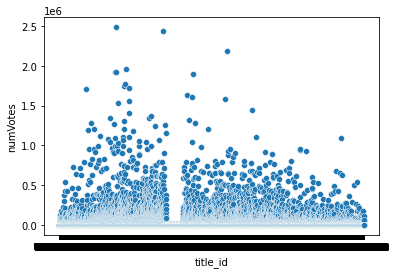

In [ ]:
# Maybe it would be better to sort by numVotes?
sns.scatterplot(x = title_ratings["title_id"][title_ratings["numVotes"]>= 1000],
                y= title_ratings["numVotes"][title_ratings["numVotes"]>= 1000])

In [ ]:
# TODO: why there are two big clusters?

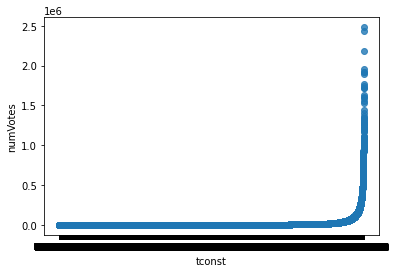

In [ ]:
# Actually regplot with tconst is not making much sense
# But helped me to see better the data
sns.regplot(x = title_ratings["title-id"][title_ratings["numVotes"]>= 1000], 
            y = title_ratings["numVotes"][title_ratings["numVotes"]>= 1000].sort_values(),
            fit_reg=False)
plt.show()

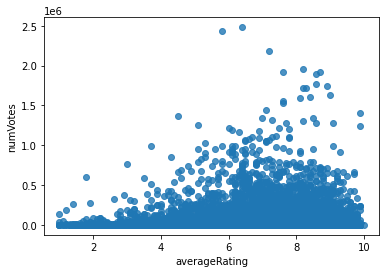

In [ ]:
# This plot makes some sense, but I cannot really interpret
sns.regplot(x = title_ratings["averageRating"][title_ratings["numVotes"]>= 1000], 
            y = title_ratings["numVotes"][title_ratings["numVotes"]>= 1000].sort_values(),
            fit_reg=True)
plt.show()

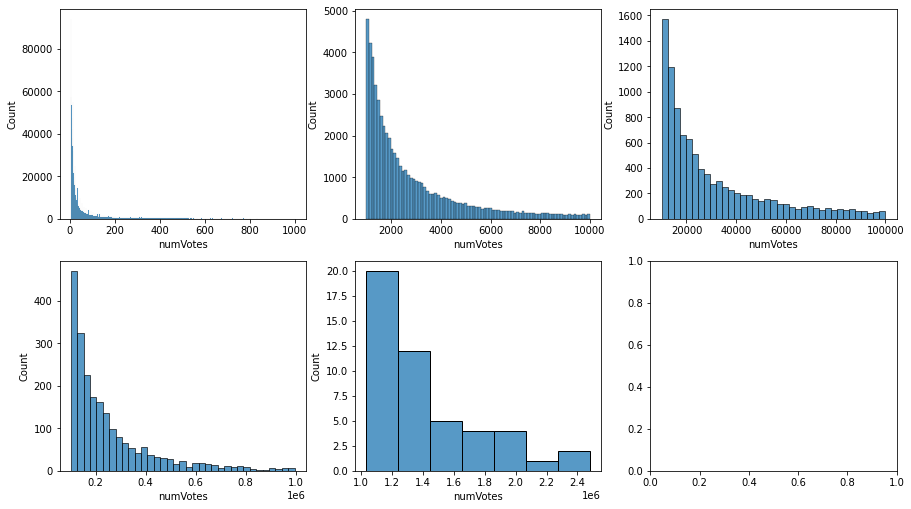

In [ ]:
# Maybe if I split data to 0-1000, 1000-10.000, 10.000-100.000, 100.000-1.000.000 and above?
fig, axes = plt.subplots(2,3, figsize = (15,8.5))

sns.histplot(ax = axes[0,0],
             data = title_ratings[title_ratings["numVotes"]<1000],
            x = title_ratings["numVotes"][title_ratings["numVotes"]<1000])
sns.histplot(ax = axes[0,1],
             data = title_ratings[(title_ratings["numVotes"]>=1000) & (title_ratings["numVotes"]<10000)],
            x = title_ratings["numVotes"][(title_ratings["numVotes"]>= 1000) & (title_ratings["numVotes"]<10000)])
sns.histplot(ax = axes[0,2],
             data = title_ratings[(title_ratings["numVotes"]>=10000) & (title_ratings["numVotes"]<100000)],
            x = title_ratings["numVotes"][(title_ratings["numVotes"]>=10000) & (title_ratings["numVotes"]<100000)])
sns.histplot(ax = axes[1,0],
             data = title_ratings[(title_ratings["numVotes"]>=100000) & (title_ratings["numVotes"]<1000000)],
            x = title_ratings["numVotes"][(title_ratings["numVotes"]>=100000) & (title_ratings["numVotes"]<1000000)])
sns.histplot(ax = axes[1,1],
             data = title_ratings[title_ratings["numVotes"]>=1000000],
            x = title_ratings["numVotes"][title_ratings["numVotes"]>=1000000])
plt.show()

# Exploring and cleaning title.akas table

In [ ]:
title_akas = pd.read_csv("https://datasets.imdbws.com/title.akas.tsv.gz", sep = "\t")
title_akas.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,5,Карменсита,RU,\N,imdbDisplay,\N,0


In [ ]:
title_akas.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29795174 entries, 0 to 29795173
Data columns (total 8 columns):
 #   Column           Non-Null Count     Dtype 
---  ------           --------------     ----- 
 0   titleId          29795174 non-null  object
 1   ordering         29795174 non-null  int64 
 2   title            29795171 non-null  object
 3   region           29795072 non-null  object
 4   language         29795174 non-null  object
 5   types            29795174 non-null  object
 6   attributes       29795174 non-null  object
 7   isOriginalTitle  29795174 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.8+ GB


**Conclusion I**:
- A.k.a: meaning "also known as"
- Looks like titleID is sth. similar to tconst.in title_basics and title_ratings;
- Ordering: not fully clear: unique? what is the logic behind?
- title: many different language and character;
- title: check for missing \\N instead of NaN;
-> title id same in the first 10 row: info is about the same movie! In different languages / regions.
- region: looks like country actually and short form; how many unique is there? is the short form aligned?
- language: lot of \\N instead of NaN;
- types: not clear type of what.
- attributes: again \\N, check what are the unique values;
- isOriginalTitle should be boolean

In [ ]:
#TODO: there is no action proposed for your conclusion

In [ ]:
title_akas[title_akas["region"] == "VDVN"]

In [ ]:
for col in title_akas:
  print(col)
  print(title_akas[col].unique())
  print(title_akas[col].value_counts())

titleId
['tt0000001' 'tt0000002' 'tt0000003' ... 'tt9916850' 'tt9916852'
 'tt9916856']
tt0168366     173
tt0076759     110
tt8185052      98
tt8446056      98
tt7014378      93
             ... 
tt7017480       1
tt10489562      1
tt4423154       1
tt5076282       1
tt3764486       1
Name: titleId, Length: 5955684, dtype: int64
ordering
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85 100 101 102 103 104
 105 106 107 108 109 110  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163

In [ ]:
# Seems that 30 mil row in some columns will be a bit too heavy for my comp. 
# Let's split the database into 4 equal parts, clean it and then concat them.
title_akas1 = title_akas[0:7434854].copy()
title_akas2 = title_akas[7434854:14869708].copy()
title_akas3 = title_akas[14869708:22304562].copy()
title_akas4 = title_akas[22304562:].copy()

# Most probably a range 1-5 and a combination with the title_akas would be enough, but for me it is easier to loop through a list.
title_akas_list = [title_akas1, title_akas2, title_akas3, title_akas4]

In [ ]:
"""for item in title_akas_list:
  print(item.info())"""

# Awesome, working as expected 

Let's convert all \\N to NaN in all 4 df for each columns.

In [ ]:
for item in title_akas_list:
  for col in item:
    item[col + "_clean"] = item[col].apply(lambda x: np.nan if x == "\\N" else x)

In [ ]:
# Let's check, if it was working. 
for item2 in title_akas_list:
  print(item2.info(null_counts = True))

**isOriginalTitle** <br>

Let's clean isOriginalTitle to fully boolean

In [ ]:
for item3 in title_akas_list:
  item3["isOriginalTitle_clean"] = item3["isOriginalTitle_clean"].apply(lambda x: x if x == 0 or x ==1 else 0 if x == "0" else 1 if x == "1" else np.nan)
  item3["isOriginalTitle_clean"] = item3["isOriginalTitle_clean"].astype(dtype = "boolean")

In [ ]:
# For the sake of it, check: 
for item4 in title_akas_list:
  print(item4.info(null_counts = True))

After the needed cleaning we can concatenate them again, while even dropping the original messy columns. **TODO** 

In [ ]:
"""for item in title_akas_list:
  title_akas_clean = pd.concat(item[""])"""

# Graph (PIE) which countries produce the most films/series?

In [ ]:
title_akas_new =pd.read_csv("/content/drive/MyDrive/title_akas_new.csv")
title_akas_new.head()

In [ ]:

top10_countries=title_akas_new['region'].value_counts()[:10]
top10_countries

In [ ]:
len(title_akas_new)

In [ ]:
#  (which countries produce the most films?
axpie = top10_countries /len(title_akas_new)
axpie
TOP10 = ["FR","JP","DE","ES","IN","IT","PT","US","GB","CA"]
plt.pie(axpie, labels=TOP10,explode=None, autopct="%2.1f%%",radius=2)
#plt.title("Top 10 Country Film Makers by %")

#plt.legend()
plt.show()

###  PIE copied from Paulo file

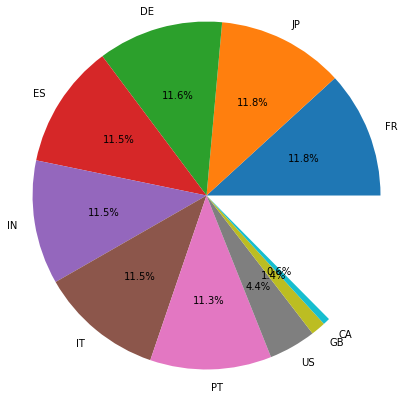

# Exploring and cleaning title.principals

Exploring and cleaning title.principals

In [ ]:
title_principals=pd.read_csv('https://datasets.imdbws.com/title.principals.tsv.gz', sep='\t')
title_principals

# tconst (string) - alphanumeric unique identifier of the title - ID. Episode???
# ordering (integer) – a number to uniquely identify rows for a given titleId
# nconst (string) - alphanumeric unique identifier of the name/person
# category (string) - the category of job that person was in
# job (string) - the specific job title if applicable, else '\N'
# characters (string) - the name of the character played if applicable, else '\N'

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
47655701,tt9916880,4,nm10535738,actress,\N,"[""Horrid Henry""]"
47655702,tt9916880,5,nm0996406,director,principal director,\N
47655703,tt9916880,6,nm1482639,writer,\N,\N
47655704,tt9916880,7,nm2586970,writer,books,\N


In [ ]:
title_principals.head()

In [ ]:
title_principals.rename(columns={'tconst':'title_id','nconst':'people_id'},inplace=True)
title_principals

NameError: ignored

In [ ]:
title_principals.info()

In [ ]:
title_principals.loc[title_principals['job'] == '\\N', 'job'] = ' '
title_principals.loc[title_principals['characters'] == '\\N', 'characters'] = ' '
title_principals


In [ ]:
title_principals.shape

In [ ]:
title_principals.dtypes

In [ ]:
title_principals.info()

In [ ]:
title_principals_missing= title_principals.isna()
title_principals_missing


In [ ]:
title_principals_num = title_principals_missing.sum()
title_principals_num 

In [ ]:
title_principals.isna()

In [ ]:
for column in title_principals:
  print(column, "the number of unique values", len(title_principals[column].unique()))
for col in title_principals.columns:
    print(col,title_principals[col].unique())

In [ ]:
for col in title_principals:
  print(col)
  print(title_principals[col].unique())
  print(title_principals[col].value_counts())

In [ ]:
for column in title_principals:
  print(column, "num of missing values: ", title_principals[column].isna().sum())

In [ ]:
title_principals["title_id"].unique()

In [ ]:
missing_value_title_principals = pd.DataFrame({'characters': title_principals.columns,
                              'percent_missing': percent_missing})
missing_value_title_principals


In [ ]:
#check duplicates

title_principals[title_principals.duplicated(subset = "characters")].sort_values(by="characters").head(20)
#A teleplay is a term for a television script;

In [ ]:
title_principals_dup=title_principals[title_principals.duplicated(subset = "category")].sort_values(by="category").head(20)
title_principals_dup

In [ ]:
title_principalsdup1=title_principals[title_principals.duplicated(subset = "job")].sort_values(by="job").head(20)
title_principalsdup1

In [ ]:
#checking if column 'title_id' always starts with 'tt':
for i in title_principals["title_id"]:
  if not i.startswith('tt'):
    print(i + ' does not start with tt')
#conclusion:always starts with 'tt'

In [ ]:
#checking if column 'nconst' always starts with 'nm':
for i in title_principals["people_id"]:
  if not i.startswith('nm'):
    print(i + ' does not start with nm')
#conclusion:always starts with 'nm'

In [ ]:
#checking if column 'tconst' always starts with '[':
for i in title_principals["characters"]:
  if not i.startswith('['):
    print(i + ' does not start with [')
#conclusion:always starts with '['

In [ ]:
title_principals.category.value_counts().plot.pie(autopct="%.0f%%", pctdistance=0.8, figsize=(7,7),
                                                          wedgeprops=dict(width=0.4))

#**Exploring** and cleaning title.episode

In [ ]:
title_episode=pd.read_csv('https://datasets.imdbws.com/title.episode.tsv.gz',sep='\t')
title_episode=title_episode.head()
title_episode=title_episode.tail()
title_episode
# tconst (string) - alphanumeric identifier of episode - change of the name of the column "ID. Episode"
# parentTconst (string) - alphanumeric identifier of the parent TV Series -change of the name "ID. TV Series"
# seasonNumber (integer) – season number the episode belongs to
# episodeNumber (integer) – episode number of the tconst in the TV series

NameError: ignored

Actions to do:

Renaming Columns 'tconst':'title_id' ('parentTconst':'IdTVseries') Converting seasonNumber and episodeNumber, as is mentioned that should be int instead of string: seasonNumber (integer) – season number the episode belongs to episodeNumber (integer) – episode number of the tconst in the TV series

In [ ]:
title_episode=title_episode.head()
title_episode=title_episode.tail()
title_episode

In [ ]:
title_episode.info()

In [ ]:
title_episode.describe()

In [ ]:
# Renaming Columns
title_episode.rename(columns={'tconst':'title_id'},inplace=True)
title_episode.rename(columns={'parentTconst':'tvseries_id'},inplace=True)
title_episode

In [ ]:
#Missing values:
title_episode.isna()

In [ ]:
nan_col = title_episode.isna().sum()
nan_col

In [ ]:
title_episode["title_id"].unique()

In [ ]:
print(title_episode["title_id"].value_count

In [ ]:
title_episode["tvseries_id"].unique()

In [ ]:
title_episode["seasonNumber"].unique()

In [ ]:
title_episode["episodeNumber"].unique()

In [ ]:
print(title_episode.loc[title_episode['title_id'] == 'tt0025509'])
#total number of episodes per serie
title_episode_total_episodes = title_episode.groupby(['title_id'])['seasonNumber'].count().reset_index()
print('total number of episodes per serie', title_episode_total_episodes)

In [ ]:
#serie with the biggest amount of episodes
print('serie with biggest amount of episodes',title_episode_total_episodes.max())

In [ ]:
#serie with the smallest amount of episodes
print('serie with the smallest amount of episodes', title_episode_total_episodes.min())

In [ ]:
#mean of episodes
print('Mean of episodes:',title_episode_total_episodes.mean())

print(title_episode['seasonNumber'].mean())

In [ ]:
#checking if column 'tconst' always starts with 'tt':
for i in title_episode["tvseries_id"]:
  if not i.startswith('tt'):
    print(i + ' does not start with tt')
#conclusion:always starts with 'tt'

In [ ]:
#checking if column 'tconst' always starts with 'tt':
for i in title_episode["title_id"]:
  if not i.startswith('tt'):
    print(i + ' does not start with tt')
#conclusion:always starts with 'tt'

# Exploring and cleaning title.crew

In [ ]:
title_crew = pd.read_csv("https://datasets.imdbws.com/title.crew.tsv.gz",sep= "\t")

In [ ]:
title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [ ]:
title_crew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8429331 entries, 0 to 8429330
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   tconst     object
 1   directors  object
 2   writers    object
dtypes: object(3)
memory usage: 192.9+ MB


In [ ]:
title_crew.describe()

,tconst,directors,writers
count,8429331,8429331,8429331
unique,8429331,838014,1148175
top,tt12649576,\N,\N
freq,1,3572110,4136332


In [ ]:
#Renaming Columns
title_crew.rename(columns={'tconst':'title_id'},inplace=True)
title_crew

In [ ]:
# check if there are null values in colums:
title_crew.isnull().sum()

tconst       0
directors    0
writers      0
dtype: int64

In [ ]:
title_crew[(title_crew.directors =='\\N' )].count

<bound method DataFrame.count of             tconst directors    writers
37       tt0000039        \N         \N
102      tt0000104        \N         \N
123      tt0000125        \N         \N
132      tt0000134        \N         \N
173      tt0000176        \N         \N
...            ...       ...        ...
8429274  tt9916738        \N  nm0665704
8429275  tt9916740        \N         \N
8429276  tt9916742        \N         \N
8429287  tt9916766        \N         \N
8429292  tt9916778        \N         \N

[3572110 rows x 3 columns]>

In [ ]:
title_crew[(title_crew.writers =='\\N' )].count

<bound method DataFrame.count of             tconst  directors writers
0        tt0000001  nm0005690      \N
1        tt0000002  nm0721526      \N
2        tt0000003  nm0721526      \N
3        tt0000004  nm0721526      \N
4        tt0000005  nm0005690      \N
...            ...        ...     ...
8429292  tt9916778         \N      \N
8429298  tt9916790  nm2317339      \N
8429304  tt9916802  nm2317339      \N
8429308  tt9916810  nm2317339      \N
8429317  tt9916830  nm4289598      \N

[4136332 rows x 3 columns]>

In [ ]:
title_crew['directors']


0                    nm0005690
1                    nm0721526
2                    nm0721526
3                    nm0721526
4                    nm0005690
                  ...         
8429326    nm5519454,nm5519375
8429327    nm5519375,nm5519454
8429328    nm5519375,nm5519454
8429329             nm10538645
8429330              nm0996406
Name: directors, Length: 8429331, dtype: object

In [ ]:
title_crew['writers']

0                                     \N
1                                     \N
2                                     \N
3                                     \N
4                                     \N
                       ...              
8429326    nm6182221,nm1628284,nm2921377
8429327    nm6182221,nm1628284,nm2921377
8429328    nm6182221,nm1628284,nm2921377
8429329                        nm6951431
8429330              nm1482639,nm2586970
Name: writers, Length: 8429331, dtype: object

In [ ]:
title_crew["directors"]= title_crew['directors'].str.split(',')


In [ ]:
title_crew['writers']=title_crew['writers'].str.split(",")

In [ ]:
title_crew

,tconst,directors,writers
0,tt0000001,[nm0005690],[\N]
1,tt0000002,[nm0721526],[\N]
2,tt0000003,[nm0721526],[\N]
3,tt0000004,[nm0721526],[\N]
4,tt0000005,[nm0005690],[\N]
...,...,...,...
8429326,tt9916848,"[nm5519454, nm5519375]","[nm6182221, nm1628284, nm2921377]"
8429327,tt9916850,"[nm5519375, nm5519454]","[nm6182221, nm1628284, nm2921377]"
8429328,tt9916852,"[nm5519375, nm5519454]","[nm6182221, nm1628284, nm2921377]"
8429329,tt9916856,[nm10538645],[nm6951431]


In [ ]:
title_crew1=title_crew.explode('directors')
title_crew1

,tconst,directors,writers
0,tt0000001,nm0005690,[\N]
1,tt0000002,nm0721526,[\N]
2,tt0000003,nm0721526,[\N]
3,tt0000004,nm0721526,[\N]
4,tt0000005,nm0005690,[\N]
...,...,...,...
8429327,tt9916850,nm5519454,"[nm6182221, nm1628284, nm2921377]"
8429328,tt9916852,nm5519375,"[nm6182221, nm1628284, nm2921377]"
8429328,tt9916852,nm5519454,"[nm6182221, nm1628284, nm2921377]"
8429329,tt9916856,nm10538645,[nm6951431]


In [ ]:
title_crew2=title_crew1.explode('writers')
title_crew2

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
8429328,tt9916852,nm5519454,nm1628284
8429328,tt9916852,nm5519454,nm2921377
8429329,tt9916856,nm10538645,nm6951431
8429330,tt9916880,nm0996406,nm1482639


#Exploring and cleaning name.basics

In [ ]:
link1 = 'https://datasets.imdbws.com/name.basics.tsv.gz'
name_basics = pd.read_csv(link1, sep = "\t")
name_basics.tail(10)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
11337786,nm9993709,Lu Bevins,\N,\N,"director,producer,writer","tt11702702,tt14508814,tt11772812,tt11772904"
11337787,nm9993710,Nestor Rudnytskyy,\N,\N,NaN,\N
11337788,nm9993711,David Gluzman,\N,\N,NaN,\N
11337789,nm9993712,Corny O'Connell,\N,\N,NaN,\N
11337790,nm9993713,Sambit Mishra,\N,\N,writer,"tt10709066,tt15134202,tt8325250,tt10449366"
11337791,nm9993714,Romeo del Rosario,\N,\N,"animation_department,art_department","tt2455546,tt11657662"
11337792,nm9993716,Essias Loberg,\N,\N,NaN,\N
11337793,nm9993717,Harikrishnan Rajan,\N,\N,cinematographer,tt8736744
11337794,nm9993718,Aayush Nair,\N,\N,cinematographer,\N
11337795,nm9993719,Andre Hill,\N,\N,NaN,\N


In [ ]:
#list of NaN values
name_basics.isna().sum()

In [ ]:
################### Cleaning job on name.basics ##################
#rename columns
name_basics.rename(columns = {'nconst': 'people_id', 'primaryName': 'people_name',  'primaryProfession': 'top3professions' }, inplace = True)

name_basics['birthYear'] = name_basics['birthYear'].apply(lambda item: np.nan if item == '\\N' else item)
name_basics['deathYear'] = name_basics['deathYear'].apply(lambda item: np.nan if item == '\\N' else item)
name_basics['knownForTitles'] = name_basics['knownForTitles'].apply(lambda item: np.nan if item == '\\N' else item)
#name_basics.tail()

In [ ]:
condition_duplicate = name_basics['people_name'].duplicated() == True
name_basics[condition_duplicate]['people_name'].unique() # 6 actors with duplicates

array(['Robert Ellis', 'Harrison Ford', 'Graham Greene', ...,
       'Shiela Martin', "Corny O'Connell", 'Romeo del Rosario'],
      dtype=object)

In [ ]:
name_basics[name_basics['people_name'] == 'Robert Ellis'] # first line (251) is the correct one

In [ ]:
name_basics[name_basics['people_name'] == 'Harrison Ford'] # first line (147) is the correct one

In [ ]:
name_basics[name_basics['people_name'] == 'Graham Greene'] # first line (1292) is the correct one

In [ ]:
name_basics[name_basics['people_name'] == 'Shiela Martin'] # not so famous...

In [ ]:
name_basics[name_basics['people_name'] == "Corny O'Connell"] # first line (2288648) is the correct one

In [ ]:
name_basics[name_basics['people_name'] == 'Romeo del Rosario'] # first line (????) is the correct one

In [ ]:
# commenbting the duplicate because these are the right person
#name_basics.drop_duplicates(subset='people_name',keep='first',inplace=True)

In [ ]:
# Changing types of values to int (not columns types)
name_basics['birthYear'] = name_basics['birthYear'].apply(lambda item: int(item) if str(item)!='nan'else item)
#name_basics['birthYear'] = name_basics['birthYear'].astype(dtype = pd.Int64Dtype())
name_basics['deathYear'] = name_basics['deathYear'].apply(lambda item: int(item) if str(item)!='nan'else item)
# Cleaning the birthYear thanks to analyse below
name_basics['birthYear'][name_basics['people_name'] == 'Therese Gotlib'] = 1998
name_basics['birthYear'][name_basics['people_name'] == 'Doguhan Kabadayi'] = 2001

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
# Adding a new column people_age
name_basics['people_age'] = name_basics[['birthYear','deathYear']].apply(lambda item: np.nan if str(item[0]) == 'nan' else ((2021 - int(item[0]) if str(item[1]) == 'nan' else item[1] - item[0])),axis=1)
name_basics['people_age'] = name_basics['people_age'].apply(lambda item: int(item) if str(item)!='nan'else item)


In [ ]:
# changing the string to a list of string to be able to use explode
name_basics['top3professions'].fillna('unknown', inplace=True)
name_basics['top3professions'] = name_basics['top3professions'].apply(lambda item: item.split(",") if ',' in item else [item])
name_basics['knownForTitles'].fillna('unknown',inplace=True)
name_basics['knownForTitles'] = name_basics['knownForTitles'].apply(lambda item: item.split(",") if ',' in item else [item])


In [ ]:
# DF with explode use name_basics_clean1 else use name_basics
#name_basics_KFT_exploded = name_basics.explode('knownForTitles') # to uncomment if we want to use knownForTitle exploded
#name_basics_KFT_exploded.head()

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
0,nm0000001,Fred Astaire,1899.0,1987.0,"[soundtrack, actor, miscellaneous]",tt0050419,122.0
0,nm0000001,Fred Astaire,1899.0,1987.0,"[soundtrack, actor, miscellaneous]",tt0072308,122.0
0,nm0000001,Fred Astaire,1899.0,1987.0,"[soundtrack, actor, miscellaneous]",tt0031983,122.0
0,nm0000001,Fred Astaire,1899.0,1987.0,"[soundtrack, actor, miscellaneous]",tt0053137,122.0
1,nm0000002,Lauren Bacall,1924.0,2014.0,"[actress, soundtrack]",tt0117057,97.0


In [ ]:
name_basics[age_zero]
#Therese Gotlib 1998 ---------> TO CHANGE
#Mae Bair 2021 --> correct
#Noah Lira 2021 --> correct
#Kenna Tota 2021 --> correct
#Rio PenaVega 2021 --> correct
#Lilibet Mountbatten-Windsor 2021 --> correct
#Grace Warrior Irwin Powell 2021 --> correct
#Legend Samuels 2021 --> correct
#Cosmo Jost 2021 --> correct
#Doguhan Kabadayi	2001 ---------> TO CHANGE

# TODO: great work chacking the values

In [ ]:
# Cleaning the birthYear ---> moved upper

#name_basics['birthYear'][name_basics['people_name'] == 'Therese Gotlib'] = 1998
#name_basics['birthYear'][name_basics['people_name'] == 'Doguhan Kabadayi'] = 2001
name_basics[name_basics['people_name'] == 'Therese Gotlib']

In [ ]:
top3professions_exploded = name_basics.explode('top3professions')

In [ ]:
categories = pd.DataFrame(top3professions_exploded['top3professions'].value_counts())
categories.reset_index(inplace=True)
categories.rename(columns={'index':'profession','top3professions':'count'},inplace=True)
categories

,profession,count
0,actor,2591423
1,unknown,2430129
2,actress,1572666
3,miscellaneous,1145205
4,producer,979331
5,writer,741203
6,camera_department,665236
7,director,604308
8,art_department,391707
9,sound_department,330566


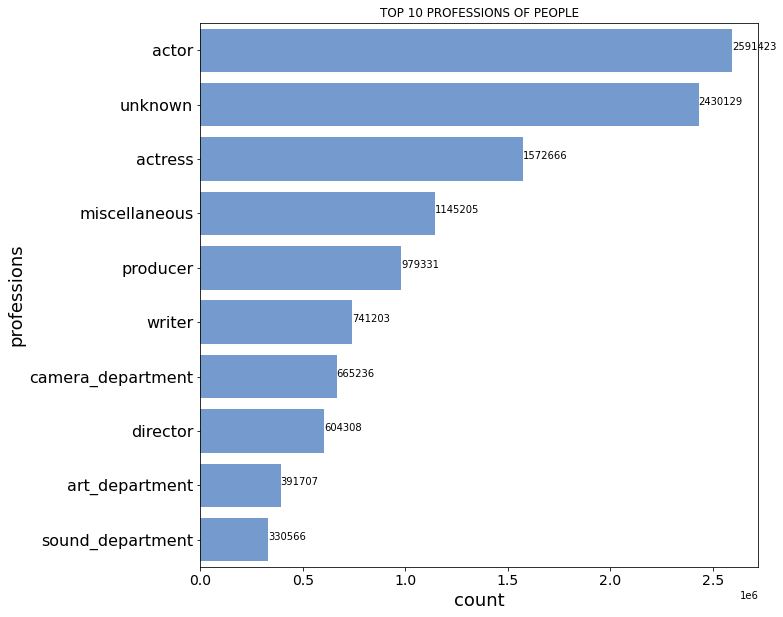

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
colors=sns.dark_palette("#69d")
plt.figure(figsize=(10,10))
sns.barplot(data=categories.head(10), y='profession',x='count',color='#69d')
plt.title("TOP 10 PROFESSIONS OF PEOPLE")
plt.xticks(fontsize=14)
plt.xlabel('count', fontsize=18)
plt.yticks(fontsize=16)
plt.ylabel('professions', fontsize=18)
#plt.legend(fontsize=10)
for index, value in enumerate(categories['count'].head(10)):
    plt.text(value, index, str(value))

In [ ]:
actor_cond= top3professions_exploded['top3professions']=='actor'
actress_cond= top3professions_exploded['top3professions']=='actress'
Actor_actress = top3professions_exploded[actor_cond|actress_cond].copy()
Actor_actress.reset_index()
#Actor_actress.drop(columns='index',axis=1)
Actor_actress.head()

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
0,nm0000001,Fred Astaire,1899.0,1987.0,actor,"[tt0053137, tt0031983, tt0072308, tt0050419]",88.0
1,nm0000002,Lauren Bacall,1924.0,2014.0,actress,"[tt0117057, tt0071877, tt0038355, tt0037382]",90.0
2,nm0000003,Brigitte Bardot,1934.0,NaN,actress,"[tt0049189, tt0057345, tt0054452, tt0056404]",87.0
3,nm0000004,John Belushi,1949.0,1982.0,actor,"[tt0077975, tt0080455, tt0072562, tt0078723]",33.0
4,nm0000005,Ingmar Bergman,1918.0,2007.0,actor,"[tt0050976, tt0060827, tt0050986, tt0083922]",89.0


In [ ]:
Actor_actress[Actor_actress['top3professions']=='actress'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1572666 entries, 1 to 11337777
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   people_id        1572666 non-null  object 
 1   people_name      1572666 non-null  object 
 2   birthYear        127494 non-null   float64
 3   deathYear        33522 non-null    float64
 4   top3professions  1572666 non-null  object 
 5   knownForTitles   1572666 non-null  object 
 6   people_age       127494 non-null   float64
dtypes: float64(3), object(4)
memory usage: 96.0+ MB


In [ ]:
# the mean of the new column age without any filtering
print("the mean of the new column age without any filtering is", round(Actor_actress['people_age'].mean(),2),"Years old")
# filtering of ages between
actor_age_zero = Actor_actress['people_age'] <= 0
actor_age_less_120 = Actor_actress['people_age'] <= 120
actor_age_positive = Actor_actress['people_age'] > 0
actor_age_above_120 = Actor_actress['people_age'] > 120
#Actor_actress Alive condition
Actor_alive = Actor_actress['deathYear'].isna()

Actor_actress[actor_age_positive&actor_age_less_120]['people_age'].value_counts().sum()
print("the mean of the new column age with filtering between 0&120 is ", round(Actor_actress[actor_age_positive&actor_age_less_120]['people_age'].mean(),2),"Years old")

the mean of the new column age without any filtering is 57.94 Years old
the mean of the new column age with filtering between 0&120 is  57.6 Years old


In [ ]:
#Mean of alive actors
Actor_actress[Actor_actress['people_age'] >0]
Actor_actress[Actor_actress['people_age'] <120]
Actor_actress['people_age'][Actor_alive&actor_age_less_120].mean()

51.372528025623424

In [ ]:
#To check age over 110
a= Actor_actress['deathYear'].isna()
b=Actor_actress['people_age']>110
Actor_actress[~a&b]

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
40010,nm0041807,Germaine Auger,1889.0,2001.0,actress,"[tt0200206, tt0030700, tt0194460, tt4789348]",112.0
230667,nm0243164,Tatzumbia Dupea,1849.0,1970.0,actress,"[tt0036677, tt0043262]",121.0
3131412,nm12263600,Ellen Reibold de La Tour,1882.0,1996.0,actress,[unknown],114.0
4311077,nm1712127,Mabel Richardson,1890.0,2001.0,actress,"[tt0014142, tt0014532]",111.0
5361147,nm2897088,Misao Ogawa,1898.0,2015.0,actress,[tt1172226],117.0


In [ ]:
Actor_actress[a&b].sort_values('people_age', axis=0, ascending=True)

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
507938,nm0537325,Antonio Maia,1910.0,NaN,actor,[tt0032652],111.0
2168184,nm1127999,Mercedes Zombory,1910.0,NaN,actress,[tt0241331],111.0
5831830,nm3417600,Shan Hu,1910.0,NaN,actress,"[tt11743198, tt0205142, tt0192018, tt12567198]",111.0
5740045,nm3317287,Colin Eaton,1910.0,NaN,actor,"[tt1379997, tt3508918, tt0250896, tt0341798]",111.0
4406193,nm1815600,Andrei Duminika,1910.0,NaN,actor,"[tt0076562, tt5292996, tt0368929, tt2236020]",111.0
...,...,...,...,...,...,...,...
6133813,nm3749829,Fanny Burt,1843.0,NaN,actress,[tt0019337],178.0
372900,nm0393833,William S. Hooser,1836.0,NaN,actor,"[tt0408145, tt0015357, tt0157755]",185.0
9739069,nm8066610,Sophie Oliver,1088.0,NaN,actress,"[tt0341134, tt14795192, tt1283913, tt5971528]",933.0
10343538,nm8810146,Paul Walsh,21.0,NaN,actor,"[tt0093223, tt0098878, tt0314567]",2000.0


In [ ]:
#Age over 125 are because missing deathYear but too many raws
Actor_actress[Actor_actress['people_age']==57]

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
112,nm0000113,Sandra Bullock,1964.0,NaN,actress,"[tt0212346, tt0111257, tt1041829, tt1454468]",57.0
114,nm0000115,Nicolas Cage,1964.0,NaN,actor,"[tt0119094, tt0113627, tt0117500, tt0435705]",57.0
127,nm0000128,Russell Crowe,1964.0,NaN,actor,"[tt0119488, tt0172495, tt0268978, tt1707386]",57.0
158,nm0000159,Teri Hatcher,1964.0,NaN,actress,"[tt0410975, tt0106057, tt0120347, tt0227538]",57.0
205,nm0000206,Keanu Reeves,1964.0,NaN,actor,"[tt0102685, tt0234215, tt0133093, tt0111257]",57.0
...,...,...,...,...,...,...,...
11138650,nm9766785,Babe Morgan,1964.0,NaN,actress,"[tt11416224, tt11251406, tt8268124, tt13232678]",57.0
11212385,nm9851102,Prachi Thakker,1964.0,NaN,actress,"[tt8439472, tt4384242, tt14325118, tt13708182]",57.0
11258854,nm9903924,Molly Maracas,1964.0,NaN,actress,[unknown],57.0
11272658,nm9919610,Detria Ward,1962.0,2019.0,actress,[tt7860576],57.0


In [ ]:
#### #### ####
Actor_actress[Actor_alive&actor_age_less_120].groupby(by=['top3professions']).count()
Actor_actress['top3professions'][Actor_alive&actor_age_less_120].value_counts()

actor      123591
actress     94959
Name: top3professions, dtype: int64

In [ ]:
Actor_actress['people_age'][Actor_alive&actor_age_less_120]

2           87.0
46          87.0
78          81.0
83          56.0
86          68.0
            ... 
11336700    25.0
11336868    34.0
11336974    27.0
11337313    24.0
11337481    33.0
Name: people_age, Length: 218550, dtype: float64

In [ ]:
MW = pd.DataFrame(Actor_actress['top3professions'].value_counts())
MW.reset_index(inplace=True)
MW.rename(columns={'index':'profession','top3professions':'count'},inplace=True)
MW.head()
MW_alive = pd.DataFrame(Actor_actress['top3professions'][Actor_alive&actor_age_less_120].value_counts())
MW_alive.reset_index(inplace=True)
MW_alive.rename(columns={'index':'profession','top3professions':'count'},inplace=True)
MW_alive
MW_dead = pd.DataFrame(Actor_actress['top3professions'][~Actor_alive&actor_age_less_120].value_counts())
MW_dead.reset_index(inplace=True)
MW_dead.rename(columns={'index':'profession','top3professions':'count'},inplace=True)
MW_dead


,profession,count
0,actor,72902
1,actress,31969


In [ ]:
MW_dead['Mean_Age'] = pd.DataFrame([69.59,72.83])
MW_dead.rename(index={0: 'dead',1: 'dead'},inplace=True)
print(MW_dead)
MW_alive['Mean_Age'] = pd.DataFrame([52.68,49.67])
MW_alive.rename(index={0: 'alive',1: 'alive'},inplace=True)
print(MW_alive)
MW['Mean_Age'] = pd.DataFrame([58.95,55.51])
MW.rename(index={0: 'dead&alive',1: 'dead&alive'},inplace=True)
print(MW)

     profession  count  Mean_Age
dead      actor  72902     69.59
dead    actress  31969     72.83
      profession   count  Mean_Age
alive      actor  123591     52.68
alive    actress   94959     49.67
           profession    count  Mean_Age
dead&alive      actor  2591423     58.95
dead&alive    actress  1572666     55.51


In [ ]:
MW

,profession,count,Mean_Age
dead&alive,actor,2591264,58.95
dead&alive,actress,1572551,55.51


In [ ]:
MW_dead

,profession,count,Mean_Age
dead,actor,72894,69.59
dead,actress,31968,72.83


In [ ]:
MW_alive

,profession,count,Mean_Age
alive,actor,123583,52.68
alive,actress,94954,49.67


In [ ]:
Actor_actress[Actor_actress['people_age']==0]

,people_id,people_name,birthYear,deathYear,top3professions,knownForTitles,people_age
3373625,nm12515594,Noah Lira,2021.0,NaN,actor,[unknown],0.0
4224617,nm1617739,Leah King,1987.0,1987.0,actress,[tt0053494],0.0
8181100,nm6110344,Bravo Delta,1990.0,1990.0,actor,"[tt9480752, tt14456826, tt3356456, tt3356522]",0.0
10635885,nm9167616,Dennis Reddy,1947.0,1947.0,actor,[tt0055403],0.0


In [ ]:
men_cond = Actor_actress['top3professions']=='actor'
women_cond = Actor_actress['top3professions']=='actress'
print("mean age for dead actor",round(Actor_actress['people_age'][men_cond&~Actor_alive&actor_age_less_120].mean(),2))
print("mean age for alive actor",round(Actor_actress['people_age'][men_cond&Actor_alive&actor_age_less_120].mean(),2))
print("mean age for dead actress",round(Actor_actress['people_age'][women_cond&~Actor_alive&actor_age_less_120].mean(),2))
print("mean age for alive actress",round(Actor_actress['people_age'][women_cond&Actor_alive&actor_age_less_120].mean(),2))
print("mean age for dead&alive actor",round(Actor_actress['people_age'][men_cond&actor_age_less_120].mean(),2))
print("mean age for dead&alive actress",round(Actor_actress['people_age'][women_cond&actor_age_less_120].mean(),2))


mean age for dead actor 69.59
mean age for alive actor 52.68
mean age for dead actress 72.83
mean age for alive actress 49.67
mean age for dead&alive actor 58.95
mean age for dead&alive actress 55.5


Text(0.5, 1.0, 'ACTRESS / ACTORS REPARTITION')

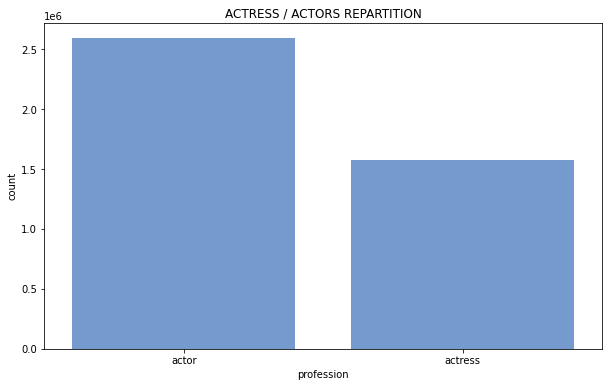

In [ ]:
plt.figure(figsize=(10,6))
colors=sns.dark_palette("#69d")
sns.barplot(data=MW, x='profession',y='count',color='#69d')
plt.title("ACTRESS / ACTORS REPARTITION")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


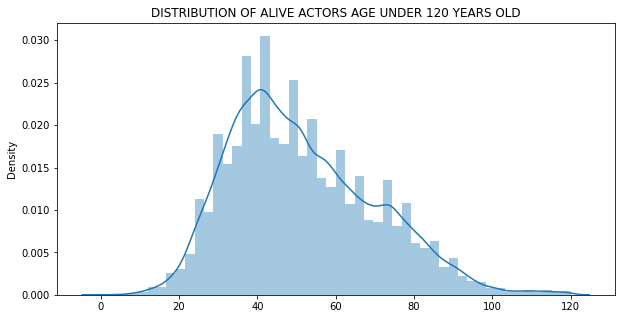

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(x=Actor_actress['people_age'][Actor_alive&actor_age_less_120])
plt.title("DISTRIBUTION OF ALIVE ACTORS AGE UNDER 120 YEARS OLD")
plt.show()


In [ ]:
# Calculating percentage of age repartition

Actor_actress[actor_age_zero]['people_age'].value_counts().sum()
print("% of people age equal or less 0 Yo",round(Actor_actress[actor_age_zero]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,3),"%")
Actor_actress[actor_age_positive&actor_age_less_120]['people_age'].value_counts().sum()
print("% of people age less than 120 Yo",round(Actor_actress[actor_age_positive&actor_age_less_120]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,2),"%") 
Actor_actress[actor_age_above_120]['people_age'].value_counts().sum()
print("% of people age above 120 Yo",round(Actor_actress[actor_age_above_120]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,2),"%")
print("Total of non NaN values in age",Actor_actress['people_age'].count())

% of people age equal or less 0 Yo 0.001 %
% of people age less than 120 Yo 99.57 %
% of people age above 120 Yo 0.43 %
Total of non NaN values in age 324806


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


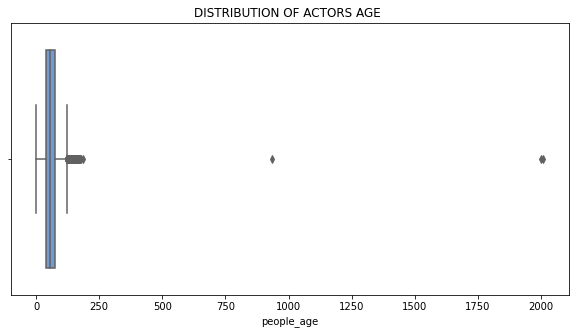

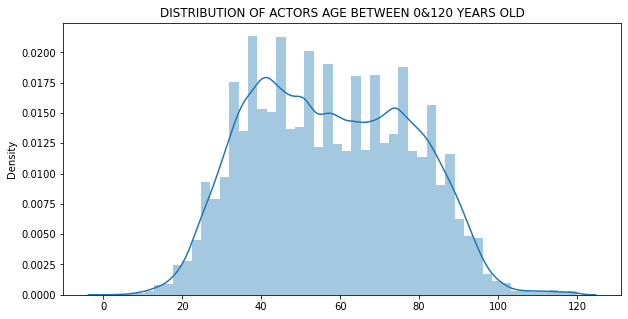

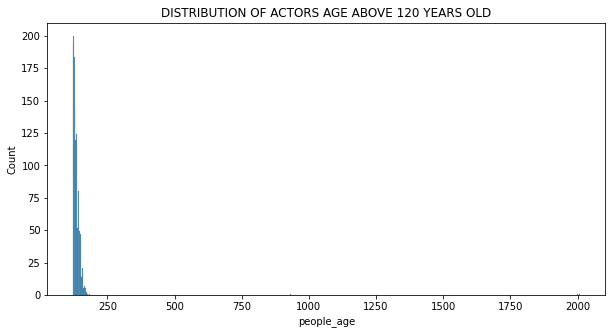

Text(0.5, 1.0, 'DISTRIBUTION OF ACTORS AGE WITH MEAN AGE = 57.6YO')

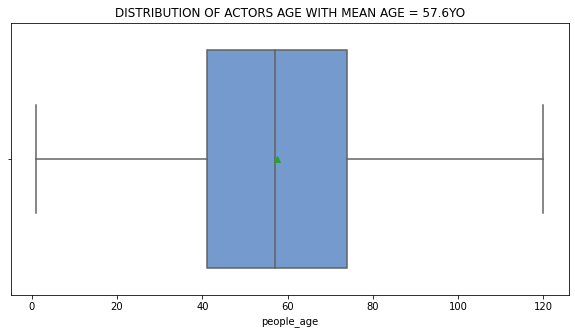

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
colors=sns.dark_palette("#69d")
plt.figure(figsize=(10,5))
sns.boxplot(data=Actor_actress,x=Actor_actress['people_age'],color='#69d')
plt.title("DISTRIBUTION OF ACTORS AGE ")
plt.figure(figsize=(10,5))
sns.distplot(x=Actor_actress[actor_age_positive&actor_age_less_120]['people_age'])
plt.title("DISTRIBUTION OF ACTORS AGE BETWEEN 0&120 YEARS OLD")
plt.show()
plt.figure(figsize=(10,5))
sns.histplot(data=Actor_actress,x=Actor_actress[actor_age_above_120]['people_age'])
plt.title("DISTRIBUTION OF ACTORS AGE ABOVE 120 YEARS OLD")
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(data=Actor_actress,x=Actor_actress[actor_age_positive&actor_age_less_120]['people_age'],showmeans=True,color='#69d')
plt.title("DISTRIBUTION OF ACTORS AGE WITH MEAN AGE = 57.6YO")

In [ ]:
name_basics['people_age'].unique()

# Question average age of actors and Age distribution


In [ ]:
# the mean of the new column age without any filtering
print("the mean of the new column age without any filtering is", round(name_basics['people_age'].mean(),2),"Years old")
# filtering of ages between
age_zero = name_basics['people_age'] <= 0
age_less_120 = name_basics['people_age'] <= 120
age_positive = name_basics['people_age'] > 0
age_above_120 = name_basics['people_age'] > 120
name_basics[age_positive&age_less_120]['people_age'].value_counts().sum()
print("the mean of the new column age with filtering between 0&120 is ", round(name_basics[age_positive&age_less_120]['people_age'].mean(),2),"Years old")

the mean of the new column age without any filtering is 58.98 Years old
the mean of the new column age with filtering between 0&120 is  58.65 Years old


In [ ]:
# Calculating percentage of age repartition

name_basics[age_zero]['people_age'].value_counts().sum()
print("% of people age equal or less 0 Yo",round(name_basics[age_zero]['people_age'].value_counts().sum()/name_basics['people_age'].count()*100,3),"%")
name_basics[age_positive&age_less_120]['people_age'].value_counts().sum()
print("% of people age less than 120 Yo",round(name_basics[age_positive&age_less_120]['people_age'].value_counts().sum()/name_basics['people_age'].count()*100,2),"%") 
name_basics[age_above_120]['people_age'].value_counts().sum()
print("% of people age above 120 Yo",round(name_basics[age_above_120]['people_age'].value_counts().sum()/name_basics['people_age'].count()*100,2),"%")
print("Total of non NaN values in age",name_basics['people_age'].count())

% of people age equal or less 0 Yo 0.004 %
% of people age less than 120 Yo 99.58 %
% of people age above 120 Yo 0.42 %
Total of non NaN values in age 537603


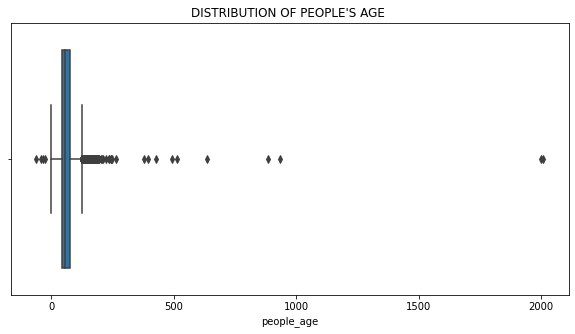

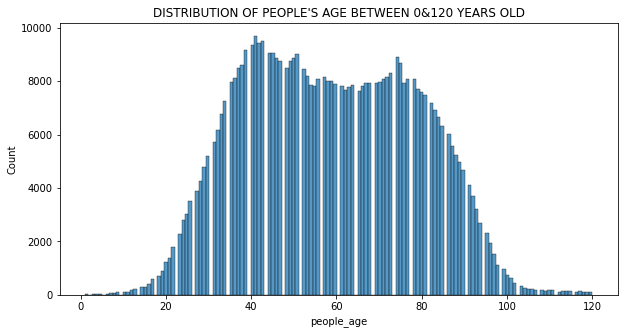

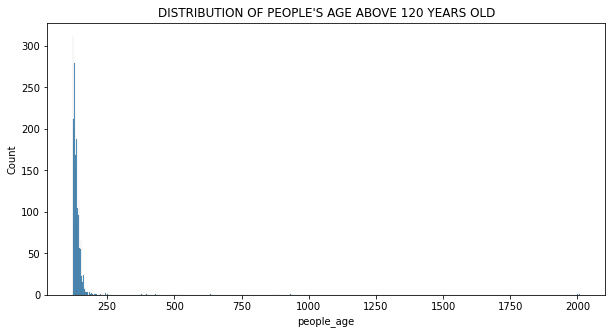

Text(0.5, 1.0, "DISTRIBUTION OF PEOPLE'S AGE WITH MEAN AGE = 58.65YO")

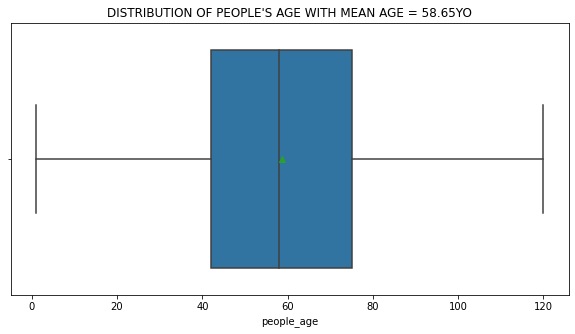

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,5))
sns.boxplot(data=name_basics,x=name_basics['people_age'])
plt.title("DISTRIBUTION OF PEOPLE'S AGE ")
plt.figure(figsize=(10,5))
sns.histplot(data=name_basics,x=name_basics[age_positive&age_less_120]['people_age'])
plt.title("DISTRIBUTION OF PEOPLE'S AGE BETWEEN 0&120 YEARS OLD")
plt.show()
plt.figure(figsize=(10,5))
sns.histplot(data=name_basics,x=name_basics[age_above_120]['people_age'])
plt.title("DISTRIBUTION OF PEOPLE'S AGE ABOVE 120 YEARS OLD")
plt.show()
plt.figure(figsize=(10,5))
sns.boxplot(data=name_basics,x=name_basics[age_positive&age_less_120]['people_age'],showmeans=True)
plt.title("DISTRIBUTION OF PEOPLE'S AGE WITH MEAN AGE = 58.65YO")

In [ ]:
#Children (00-14 years)
children_cond = Actor_actress['people_age'] <= 14
print("% of Children (00-14 years)",round(Actor_actress[children_cond]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,3),"%")

#Youth (15-24 years)
age_plus_14 = Actor_actress['people_age'] >14
age_under_25 = Actor_actress['people_age'] <=24
youth_cond = age_plus_14&age_under_25
print("% of Youth (15-24 years)",round(Actor_actress[youth_cond]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,3),"%")

#Adults (25-64 years)
age_plus_25 = Actor_actress['people_age'] >=25
age_under_64 = Actor_actress['people_age'] <=64
adult_cond = age_plus_25&age_under_64
print("% of Adults (25-64 years)",round(Actor_actress[adult_cond]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,3),"%")


#Seniors (65 years and over)
age_plus_65 = Actor_actress['people_age'] >=65
print("% of Seniors (65 years and over)",round(Actor_actress[age_plus_65]['people_age'].value_counts().sum()/Actor_actress['people_age'].count()*100,3),"%")


% of Children (00-14 years) 0.275 %
% of Youth (15-24 years) 2.6 %
% of Adults (25-64 years) 58.375 %
% of Seniors (65 years and over) 38.75 %


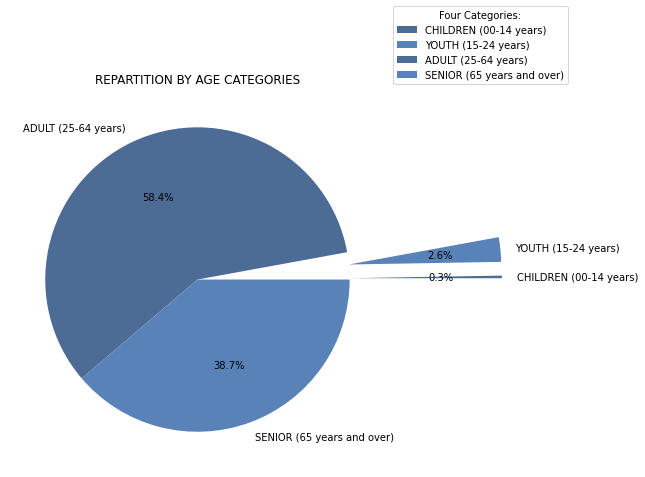

In [ ]:
# Plot
from seaborn import dark_palette,light_palette
age_categories = ['CHILDREN (00-14 years)', 'YOUTH (15-24 years)', 'ADULT (25-64 years)',
        'SENIOR (65 years and over)']
  
data = [0.275, 2.6, 58.375, 38.75]
  
# Creating plot
#palette could be:
#colors = sns.cubehelix_palette(start=.5, rot=-.5)
#colors = sns.color_palette("ch:start=.2,rot=-.3")
colors=sns.dark_palette("#69d")[3:5]
#colors = sns.color_palette('Blues')#[0:5] #list of palette "crest",
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = age_categories,autopct="%2.1f%%",explode= [1,1,0,0],colors=colors)#,colors=['blue','royalblue','deepskyblue','skyblue'])
plt.legend(title = "Four Categories:",loc='lower left',bbox_to_anchor=(1,1)) 

plt.title("REPARTITION BY AGE CATEGORIES") 
# show plot
plt.show()

# Question are the actors in movie the same as in tv series ?

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tvSeries_movie_names=pd.read_csv('/content/drive/MyDrive/tvSeries_movie_names.csv', sep=',')
tvSeries_movie_names.head()

,Unnamed: 0,people_id,title_id,category,titleType,pT_clean,oT_clean,people_name
0,0,nm0215752,tt0000502,actor,movie,Bohemios,Bohemios,Antonio del Pozo
1,1,nm0252720,tt0000502,actor,movie,Bohemios,Bohemios,El Mochuelo
2,2,nm0846887,tt0000574,actress,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,Elizabeth Tait
3,3,nm0846894,tt0000574,actor,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,John Tait
4,4,nm1431224,tt0000574,actor,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,Nicholas Brierley


In [ ]:
tvSeries_movie_names.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [ ]:
result = pd.merge(tvSeries_movie_names,tvSeries_movie_names['titleType'].str.get_dummies(),how='left',right_index=True,left_index=True)

In [ ]:
result_plot = result.pivot_table( values=['movie','tvSeries'],columns='people_name' ,aggfunc='sum').T
result_plot.reset_index(inplace=True)
result_plot.head()
#result_plot.shape

,people_name,movie,tvSeries
0,''Knife'' Sotelo,2,0
1,'Ace Primo' Niko Warren,1,0
2,'Aisea Latu,0,1
3,'Aunty' Mary Hooker,1,0
4,'Baby' Carmen De Rue,5,0


In [ ]:
#Building conditions to filter
c1movie=result_plot['movie']>0
c2serie=result_plot['tvSeries']>0
result_plot[c1movie & c2serie]
#building list of names per categories
movie_name = list(result_plot['people_name'][c1movie])
tvserie_name = list(result_plot['people_name'][c2serie])
movie_notserie_name = list(result_plot['people_name'][c1movie&~c2serie])
tvserie_notmovie_name = list(result_plot['people_name'][c2serie&~c1movie])


In [ ]:
#Calculate the repartition
print("Actor(ess) having a role in Movie or TvSeries =",result_plot.shape[0])
print("Actor(ess) having a role in Movie =",result_plot[c1movie].shape[0])
print(round(result_plot[c1movie].shape[0]/result_plot.shape[0]*100,2),"%")
print("Actor(ess) having a role in TvSeries =",result_plot[c2serie].shape[0])
print(round(result_plot[c2serie].shape[0]/result_plot.shape[0]*100,2),"%")
print("Actor(ess) having a role in Movie&TvSeries =",result_plot[c1movie&c2serie].shape[0])
print(round(result_plot[c1movie&c2serie].shape[0]/result_plot.shape[0]*100,2),"%")

Actor(ess) having a role in Movie or TvSeries = 762546
Actor(ess) having a role in Movie = 553521
72.59 %
Actor(ess) having a role in TvSeries = 329868
43.26 %
Actor(ess) having a role in Movie&TvSeries = 120843
15.85 %


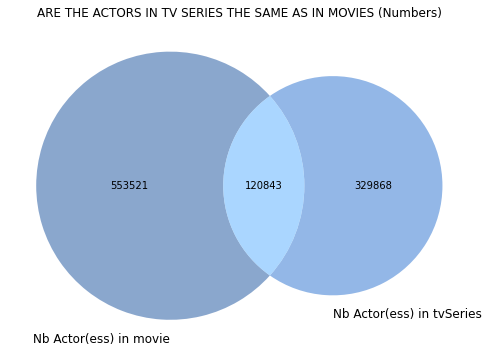

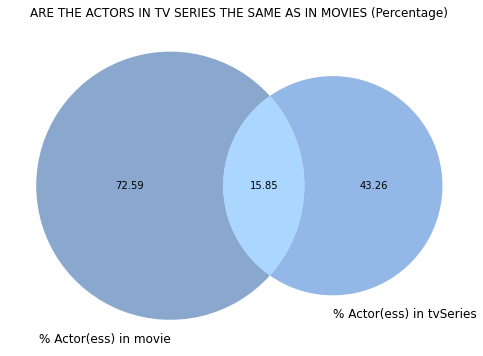

In [ ]:
#Plot of repartition
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib import pyplot as plt
#
colors=sns.dark_palette("#69d")[4:6]
plt.figure(figsize=(10,6))
venn2(subsets = (553521, 329868, 120843), set_labels = ('Nb Actor(ess) in movie', 'Nb Actor(ess) in tvSeries'), set_colors=(colors), alpha = 0.7);
plt.title('ARE THE ACTORS IN TV SERIES THE SAME AS IN MOVIES (Numbers)')
plt.show()
#
plt.figure(figsize=(10,6))
venn2(subsets = (72.59, 43.26, 15.85), set_labels = ('% Actor(ess) in movie', '% Actor(ess) in tvSeries'), set_colors=(colors), alpha = 0.7);
plt.title('ARE THE ACTORS IN TV SERIES THE SAME AS IN MOVIES (Percentage)')
plt.show()


# List 10 actors appear more movies/series- (merge principals with name.basics) 

In [ ]:
######  lets check the Data  actors_principals

actors_principals_final =pd.read_csv("/content/drive/MyDrive/actors_principals_final.csv")
actors_principals_final.head()

In [ ]:
actors_principals_final[actors_principals_final['top3professions']=='actor']['people_name'].value_counts()[:10]

Delhi Kumar            7834
Subhalekha Sudhakar    7146
Yuma Sanada            5849
Peter Hobbs            5037
Sebastian Hofmeyr      4422
Tony Ramos             4331
Guy Sanche             4111
Bhaswar Chatterjee     4091
Sajan Surya            4043
Francisco Cuoco        3988

In [ ]:
## both filters same result
actors_principals_final[actors_principals_final['category']=='actor']['people_name'].value_counts()[:10]

Delhi Kumar            7834
Subhalekha Sudhakar    7146
Yuma Sanada            5849
Peter Hobbs            5037
Sebastian Hofmeyr      4422
Tony Ramos             4331
Guy Sanche             4111
Bhaswar Chatterjee     4091
Sajan Surya            4043
Francisco Cuoco        3988

#  List 10 ACTRESS APPEAR MORE movies/series

In [ ]:
actress =pd.read_csv("/content/drive/MyDrive/actress.csv")
actress.head()

In [ ]:
title_principals1 =pd.read_csv("/content/drive/MyDrive/title_principals1.csv")
title_principals1.head()

In [ ]:
actress_principals = pd.merge(actress,
                       title_principals1,
                       how = "outer",
                       left_on = "people_id",
                       right_on = "people_id")

In [ ]:
actress_principals.head()

In [ ]:
actress_principals[actress_principals['top3professions']=='actress']['people_name'].value_counts()[:10]

Sameera Sherief        9708
Radhika Sarathkumar    8623
Judy Sheindlin         8423
Vanna White            7186
Agnes Nixon            6443
Oprah Winfrey          6424
Neha Gowda             6213
Sudha Chandran         5880
Carol Vorderman        5781
Jada Rowland           5628
Name: people_name, dtype: int64

In [ ]:
#### this is better
actress_principals[actress_principals['category']=='actress']['people_name'].value_counts()[:10]

Sameera Sherief          9708
Neha Gowda               6213
Sudha Chandran           5878
Jada Rowland             5628
Pallavi Ramisetty        5606
Manuela do Monte         5202
Vadivukkarasi            5055
Giovanna Grigio          5013
Brümilda van Rensburg    4453
Christine Basson         4432
Name: people_name, dtype: int64

# Combining movies and ratings

In [ ]:
title_basics.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres', 'endYear_clean',
       'startYear_clean', 'isAdult_clean', 'runTimeMin_clean', 'pT_clean',
       'oT_clean'],
      dtype='object')

In [ ]:
title_ratings.columns

Index(['tconst', 'averageRating', 'numVotes'], dtype='object')

In [ ]:
title_basics.loc[title_basics['genres'] == '\\N', 'genres'] = 'other'
title_basics['genres'].fillna('other',inplace=True)

In [ ]:
title_total = pd.merge(title_basics,
                       title_ratings,
                       how = "left",
                       left_on = "title_id",
                       right_on = "title_id")
print(title_total.head())

      tconst titleType  ... averageRating numVotes
0  tt0000001     short  ...           5.7   1834.0
1  tt0000002     short  ...           6.0    236.0
2  tt0000003     short  ...           6.5   1593.0
3  tt0000004     short  ...           6.0    153.0
4  tt0000005     short  ...           6.2   2410.0

[5 rows x 17 columns]


In [ ]:
title_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8419764 entries, 0 to 8419763
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   tconst            object 
 1   titleType         object 
 2   primaryTitle      object 
 3   originalTitle     object 
 4   isAdult           object 
 5   startYear         object 
 6   endYear           object 
 7   runtimeMinutes    object 
 8   genres            object 
 9   endYear_clean     Int64  
 10  startYear_clean   Int64  
 11  isAdult_clean     boolean
 12  runTimeMin_clean  Int64  
 13  pT_clean          object 
 14  oT_clean          object 
 15  averageRating     float64
 16  numVotes          float64
dtypes: Int64(3), boolean(1), float64(2), object(11)
memory usage: 1.1+ GB


In [ ]:
title_movie = title_total[(title_total["titleType"] == "movie") | (title_total["titleType"] == "tvMovie")]
sorted_movies_byvotes = title_movie.sort_values(by="numVotes",ascending=False)
top20byvote = sorted_movies_byvotes[["numVotes","primaryTitle","startYear", "genres","averageRating", "runtimeMinutes"]].iloc[:20,:]
top20byvote

In [ ]:
#First table to show:
top20byvote = sorted_movies_byvotes[["numVotes","primaryTitle","startYear", "genres","averageRating", "runtimeMinutes"]].iloc[:20,:]
top20byvote['numVotes'] = top20byvote.apply(lambda x: "{:,}".format(x['numVotes']), axis=1)
top20byvote


In [ ]:
#Starting describing the common charactersistics 'List the Top 20 movies and Average Rating':
sns.boxplot(y = top20byvote["averageRating"]).set(title='List the Top 20 movies and Average Rating')
plt.show()


In [ ]:
sns.boxplot(y = top20byvote["runtimeMinutes"]).set(title='List the Top 20 movies and runtime')
plt.show()

In [ ]:
sns.boxplot(y = top20byvote["startYear"]).set(title='List the Top 20 movies and Year')
plt.show()

In [ ]:
#top 5 movies between 2015 and 2020:
valuesPerYear = pd.DataFrame(columns=["numVotes","primaryTitle","startYear", "genres","averageRating", "runtimeMinutes"])
sorted_movies_byvotes = title_movie.sort_values(by="numVotes",ascending=False)
for i in range(2015, 2021):
   by_year = sorted_movies_byvotes[sorted_movies_byvotes["startYear"] == i]
   full_data = by_year[["numVotes","primaryTitle","startYear", "genres","averageRating", "runtimeMinutes"]].iloc[:5,:]
   valuesPerYear = valuesPerYear.append(full_data)
#total number of votes
dataPerYear = pd.DataFrame(columns=["numVotes","primaryTitle","startYear", "genres","averageRating", "runtimeMinutes"])#full data
for i in range(2015, 2021):
   by_year = sorted_movies_byvotes[sorted_movies_byvotes["startYear"] == i]
   dataPerYear = dataPerYear.append(by_year)

print(dataPerYear.groupby('startYear').mean())
#creating new column 'Distance_to_max':
for i in valuesPerYear.index:
   valuesPerYear.at[i, "Distance_to_max"] = 2488195 - valuesPerYear.at[i, "numVotes"]

valuesPerYear

In [ ]:
myTable= PrettyTable([ "Start Year", "Num Votes", "Average Rating", "runtimeMinutes"])
myTable.add_row(["2015", "3059.14", "6.29", "86.07"]) 
myTable.add_row(["2016","3130.91","6.29", "85.60"]) 
myTable.add_row(["2017", "2727.84", "6.29", "86.62"])
myTable.add_row(["2018","2515.11", "6.20", "88.00"])
myTable.add_row(["2019", "2549.53", "6.20", "91.29"])
myTable.add_row(["2020", "1598.07", "6.22", "90.10"])
print(myTable)

In [ ]:
top20byvote.genres.value_counts().plot.pie(autopct="%.0f%%", pctdistance=0.8, figsize=(7,7),
                                                          wedgeprops=dict(width=0.4))

plt.title("List the Top 20 movies with the highest voter count per genre combination")
plt.show()

In [ ]:
#Visualization for movies with highest rating (== 10):
title_movie[title_movie["averageRating"] == 10].sort_values(by = "numVotes", ascending = False).head(20)


In [ ]:
title_totalratings= pd.merge(title_ratings,title_basics,on="title_id",how="right").sort_values(by="averageRating",ascending=False)
sorted_movies_byrating = total_ratings.sort_values(by="averageRating",ascending=False)
sorted_movies_byrating=sorted_movies_byrating[sorted_movies_byrating["averageRating"] == 10]
sorted_movies_byrating
sorted_movies_byrating[sorted_movies_byrating["averageRating"] == 10].sort_values(by = "numVotes", ascending = False).head(20)

In [ ]:
#Another table to show:
sorted_movies_byrating1=sorted_movies_byrating[["numVotes","primaryTitle","startYear", "genres","titleType"]].sort_values(by = "numVotes", ascending = False).head(20)
sorted_movies_byrating1

NameError: ignored

# Create a modell

In [ ]:
title_total.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres', 'endYear_clean',
       'startYear_clean', 'isAdult_clean', 'runTimeMin_clean', 'pT_clean',
       'oT_clean', 'averageRating', 'numVotes'],
      dtype='object')

First define target and explanatories

In [ ]:
# Explanatory variables: let's use the numericals
X = [['endYear_clean','startYear_clean', 'isAdult_clean', 'runTimeMin_clean',  'averageRating', 'numVotes']]
# Target is to provide a primaryTitle / or a list of titles
y = ["primaryTitle"]

# Let's check closest distance on movies:
# So based on one movie you can recommend another
distanceKNN = NearestNeighbors(n_neighbors=2).fit(X)


Find one close neighbour and print 

In [ ]:
# TODO: good work. I can see you are starting reasoning on the numbers, keep going!

In [ ]:
name_basics['people_id'].nunique()

11356011